In [1]:
"""Further analysis plots and tables"""

'Further analysis plots and tables'

To do: 
- Table of significant targets and nr of associated AEs in each dataset
- Violin/raincloud plots for top 15 targets
- Violin/raincloud plots per target class
- Violin/raincloud plots per SOC
- FAERS vs SIDER LR and PPV distributions twin violins



- association LR and PPV with prevalence


In [2]:
"RAINPY ENVIRONMENT for petit prince raincloud plots"

'RAINPY ENVIRONMENT for petit prince raincloud plots'

In [3]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import urllib.parse
import urllib.request
from ptitprince import PtitPrince as pt
import seaborn as sns
import numpy as np
import datetime

In [4]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns',200)

In [5]:
basedir = '/scratch/ias41/ae_code'

In [6]:
with open(basedir + '/analysis/data/dirs_info.pkl', 'rb') as f:
    dirs = pickle.load(f)

In [7]:
faers_data = dirs['20200110_faers_unbound_margin_pred_005_PRR2']
sider_data = dirs['20200110_sider_unbound_margin_pred']
combined_destination_dir = 'unbound_margin_pred_faers_vs_sider'

In [8]:
target_info_file = basedir + '/ae_target_links/data/target_names.txt'
# Target information
target_info = pd.read_csv(target_info_file, sep='\t')
target_info = target_info.loc[target_info['accession_organism']=='Homo sapiens',:]

In [9]:
# Load main info with performance metrics
faers_dir = faers_data['dir']
sider_dir = sider_data['dir']
faers_pos_perf = pd.read_csv(basedir + f'/ae_target_links/output/{faers_dir}/sign_assoc_performance.txt', sep='\t')
faers_sign_perf = pd.read_csv(basedir + f'/ae_target_links/output/{faers_dir}/sign_assoc_performance.txt', sep='\t')
sider_pos_perf = pd.read_csv(basedir + f'/ae_target_links/output/{sider_dir}/sign_assoc_performance.txt', sep='\t')
sider_sign_perf = pd.read_csv(basedir + f'/ae_target_links/output/{sider_dir}/sign_assoc_performance.txt', sep='\t')

In [10]:
# Previously reported associations
# Known associations, merge with known hierarchy HLT
known_associations = pd.read_excel(basedir + '/prev_reported_safety_associations/data/safety_meddra_annotated_effects.xls')
known_associations['Annotated MedDRA PT'] = known_associations['Annotated MedDRA PT'].apply(lambda x: x.upper())
known_meddra_hier = pd.read_excel(basedir + '/prev_reported_safety_associations/data/safety_meddra_annotated_effects_for_hierarchy_output.xlsx', skiprows=4)
known_meddra_hier['PT'] = known_meddra_hier['PT'].apply(lambda x: x.upper())
known_meddra_hier[' Term'] = known_meddra_hier[' Term'].apply(lambda x: x.upper())
known_meddra_hier['HLT'] = known_meddra_hier['HLT'].apply(lambda x: x.upper())
known_meddra_hier_selection = known_meddra_hier.loc[known_meddra_hier['Primary SOC']=='Y',['PT','HLT',' Term']].drop_duplicates()
known_merged = known_associations.merge(known_meddra_hier_selection, left_on='Annotated MedDRA PT', right_on=' Term')

hlt_manual = pd.read_excel(basedir + '/prev_reported_safety_associations/data/safety_meddra_manually_annotated_hlt_effects.xls', index=False)
hlt_manual.rename(columns={'Annotated MedDRA HLT': 'HLT'}, inplace=True)
hlt_manual['HLT'] = hlt_manual['HLT'].apply(lambda x: x.upper())
hlt_manual.drop(columns=['Annotated MedDRA HLT Code'])

known_merged = pd.concat([known_merged, hlt_manual], sort=False).reset_index(drop=True)

# MedDRA hierchy
meddra_hier = pd.read_excel(basedir + '/analysis/data/all_faers_and_sider_aes_hier_output.xlsx', skiprows=4)
meddra_hier_selection = meddra_hier.loc[meddra_hier['Primary SOC']=='Y',[' Term','HLT','SOC','PT']].drop_duplicates()
meddra_hier_selection['HLT'] = meddra_hier_selection['HLT'].apply(lambda x: x.upper())

In [11]:
known_tuples = set([(x[1]['Accession'], x[1]['HLT']) for x in known_merged.iterrows()])

### Table of nr of targets associated in FAERS and SIDER per target

In [12]:
def comparison_table(df1_assoc, dataset1_name, df2_assoc, dataset2_name, target_info):
    """Return df with nr of AEs per target comparing the two association dfs.
    kwargs: df1/df2_assoc -- pandas dataframe with target-AE associations and LRs
    dataset1/2_name -- str name of experiment/dataset
    target_info -- pandas df with 'pref_name' and 'accession' for targets"""
    
    if len(df1_assoc) > len(df2_assoc):
        print('main_df = DF1')
        main_df = df1_assoc
        other_df = df2_assoc
        main_df_name = dataset1_name
        other_df_name = dataset2_name
    elif len(df2_assoc) > len(df1_assoc):
        main_df = df2_assoc
        other_df = df1_assoc   
        main_df_name = dataset2_name
        other_df_name = dataset1_name
    comparison_info = []
    for target in set(main_df['accession']) | set(other_df['accession']):

        target_name = list(target_info.loc[target_info['accession']==target,'pref_name'])[0]
        
        main_aes = set(main_df.loc[main_df['accession']==target,'Adverse Event'])
        other_aes = set(other_df.loc[other_df['accession']==target,'Adverse Event'])
        overlapping_aes = len(main_aes & other_aes)
        perc_unique_aes_overlapping = (overlapping_aes / len(main_aes | other_aes))*100
        
        main_hlts = set(main_df.loc[main_df['accession']==target,'HLT'])
        other_hlts = set(other_df.loc[other_df['accession']==target,'HLT'])
        overlapping_hlts = len(main_hlts & other_hlts)
        perc_unique_hlts_overlapping = (overlapping_hlts / len(main_hlts | other_hlts))*100
        
        info = (target, target_name, len(main_aes), len(other_aes), perc_unique_aes_overlapping, perc_unique_hlts_overlapping)
        comparison_info.append(info)
    
    info_df = pd.DataFrame(comparison_info, columns=['Accession','Protein', 'Number of unique associated AEs ({})'.format(main_df_name), 'Number of unique associated AEs ({})'.format(other_df_name),'% Unique adverse events overlapping', '% Unique HLTs overlapping']).sort_values(by=['% Unique adverse events overlapping', 'Number of unique associated AEs ({})'.format(main_df_name), 'Number of unique associated AEs ({})'.format(other_df_name)], ascending=[False,False,False]).reset_index(drop=True)
    info_df['% Unique HLTs overlapping'] = info_df['% Unique HLTs overlapping'].apply(lambda x: '{:.1f}'.format(x))
    info_df['% Unique adverse events overlapping'] = info_df['% Unique adverse events overlapping'].apply(lambda x: '{:.1f}'.format(x))
    
    return info_df

In [13]:
faers_sign_perf_merged = faers_sign_perf.merge(meddra_hier_selection, left_on='Adverse Event', right_on=' Term')
sider_sign_perf_merged = sider_sign_perf.merge(meddra_hier_selection, left_on='Adverse Event', right_on=' Term')

In [14]:
faers_vs_sider = comparison_table(df1_assoc=faers_sign_perf_merged, dataset1_name='FAERS', df2_assoc=sider_sign_perf_merged, dataset2_name = 'SIDER', target_info=target_info)

In [15]:
faers_vs_sider['Target not on current safety panels'] = faers_vs_sider['Accession'].apply(lambda x: 0 if x in set(known_merged['Accession']) else 1)

In [16]:
faers_vs_sider.head()

,Accession,Protein,Number of unique associated AEs (SIDER),Number of unique associated AEs (FAERS),% Unique adverse events overlapping,% Unique HLTs overlapping,Target not on current safety panels
0,P14416,Dopamine D2 receptor,31,15,7.0,10.3,0
1,P35462,Dopamine D3 receptor,13,8,5.0,5.3,1
2,P31645,Serotonin transporter,6,22,3.7,4.3,0
3,P28223,Serotonin 2a (5-HT2a) receptor,9,27,2.9,3.2,0
4,Q9Y2D0,Carbonic anhydrase VB,27,0,0.0,0.0,1


In [29]:
# Save file
faers_vs_sider.to_csv(basedir + f'/analysis/results/{combined_destination_dir}/faers_vs_sider_ae_overlap.txt', sep='\t', index=False)

### Violin/raincloud plots for top 10 targets

In [17]:
accession_string = ' '.join(list(set(faers_pos_perf['accession']) | set(sider_pos_perf['accession'])))
url = 'https://www.uniprot.org/uploadlists/'

params = {
'from': 'UNIPROTKB AC/ID',
'to': 'GENENAME',
'format': 'tab',
'query': f'{accession_string}'
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
    response = f.read().decode('utf-8')
    
uniprot2gene_id = dict()
for item in response.split('\n')[1:-1]:
    uniprot2gene_id[item.split('\t')[0]] = item.split('\t')[1]

In [18]:
faers_sign_perf_merged['dataset'] = 'FAERS'
sider_sign_perf_merged['dataset'] = 'SIDER'

In [19]:
faers_sign_perf_merged.columns

Index(['accession', 'nr compounds', 'nr compounds with AE', 'ae_hit_rate',
       'nr compounds without AE', 'nae_hit_rate', 'nr compounds active',
       'nr compounds inactive', 'Adverse Event', 'Likelihood Ratio', 'p-value',
       'activity_vector', 'ae_vector', 'molregnos', 'active_molregnos',
       'predicted_vector', 'corrected p-value', 'tid', 'pref_name',
       'target_type', 'accession_organism', 'target_organism', 'PPV',
       'ae_prevalence', 'specificity', 'PRU', 'improvement_over_prevalence',
       ' Term', 'HLT', 'SOC', 'PT', 'dataset'],
      dtype='object')

In [20]:
combined_sign = pd.concat([faers_sign_perf_merged, sider_sign_perf_merged])[['pref_name', 'nr compounds', 'nr compounds with AE', 'ae_hit_rate',
       'nr compounds without AE', 'nae_hit_rate', 'nr compounds active',
       'nr compounds inactive', 'Adverse Event', 'Likelihood Ratio',
       'corrected p-value','PPV','ae_prevalence',
       'dataset','accession','PRU', 'improvement_over_prevalence', 'specificity']]

In [21]:
combined_sign_no_inf = combined_sign.copy()

faers_max = max(combined_sign.loc[(combined_sign['Likelihood Ratio']!=np.inf)&(combined_sign['dataset']=='FAERS'),'Likelihood Ratio'])
sider_max = max(combined_sign.loc[(combined_sign['Likelihood Ratio']!=np.inf)&(combined_sign['dataset']=='SIDER'),'Likelihood Ratio'])

def replace_infs(x):
    if x['Likelihood Ratio'] == np.inf:
        if x['dataset'] == 'FAERS':
            return faers_max
        elif x['dataset'] == 'SIDER':
            return sider_max
    else:
        return x['Likelihood Ratio']

combined_sign_no_inf['Likelihood Ratio'] = combined_sign_no_inf.apply(replace_infs, axis=1)

In [22]:
top_uniprots = pd.DataFrame(combined_sign_no_inf.groupby('accession')['Adverse Event'].count()).sort_values(by='Adverse Event', ascending=False).index[:15]
combined_sign_selected = combined_sign_no_inf.loc[combined_sign_no_inf['accession'].isin(top_uniprots)]

In [23]:
combined_sign_selected = combined_sign_selected.merge(meddra_hier_selection, left_on='Adverse Event', right_on=' Term')
def find_known(row):
    if ((row['accession'],row['HLT'])) in known_tuples:
        return 1
    else:
        return 0
    
combined_sign_selected['known association'] = combined_sign_selected.apply(find_known, axis=1)

In [24]:
sorted_uniprots = list(combined_sign_selected.groupby('accession')['PPV'].median().sort_values(ascending=False).index)

In [25]:
sorterIndex = dict(zip(sorted_uniprots,range(len(top_uniprots))))
combined_sign_selected['Rank'] = combined_sign_selected['accession'].map(sorterIndex)
combined_sign_selected['Target'] = combined_sign_selected['accession'].apply(lambda x: uniprot2gene_id[x] + '\n(n={})'.format(len(combined_sign_selected.loc[combined_sign_selected['accession']==x,'Adverse Event'])))

In [26]:
df_known = combined_sign_selected.loc[combined_sign_selected['known association']==1]

to_add = []
for accession in set(combined_sign_selected['accession']) - set(df_known['accession']):
    gene_symbol = uniprot2gene_id[accession]
    size = str(len(combined_sign_selected.loc[combined_sign_selected['accession']==accession,'Adverse Event']))
    rank = list(combined_sign_selected.loc[combined_sign_selected['accession']==accession,'Rank'])[0]
    to_add.append({'Target': gene_symbol + '\n(n={})'.format(size), 'Rank': rank})
    
    #print(uniprot2gene_id[accession]), print(len(combined_sign_selected.loc[combined_sign_selected['accession']==accession,'Adverse Event']))

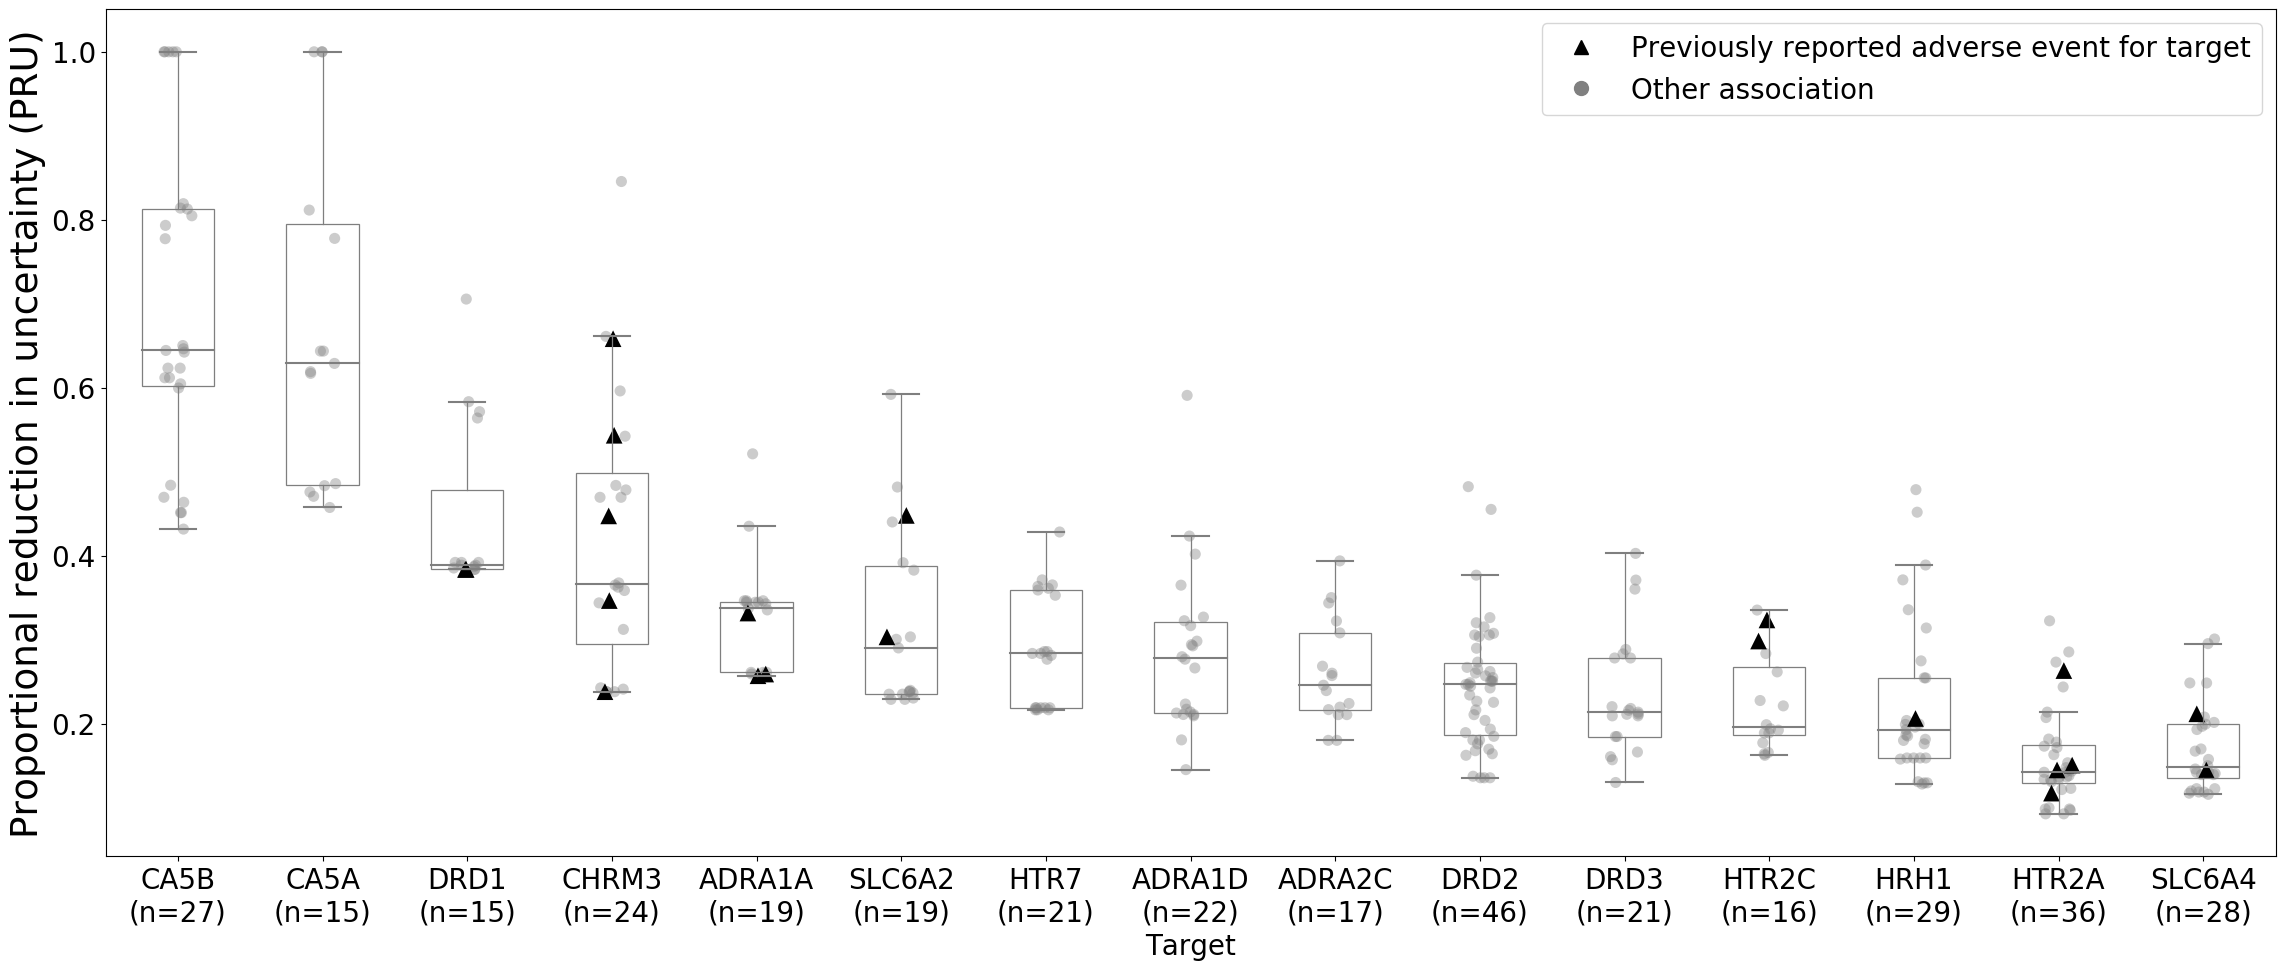

In [27]:
plt.rcdefaults()
plt.rcParams.update({'font.size': 20})

pal = "Set2"
dy="PRU"; dx="Target"; ort="v"; #pal = sns.color_palette(n_colors=1)
df = combined_sign_selected.sort_values(by='Rank')
df_new = combined_sign_selected.loc[combined_sign_selected['known association']==0].sort_values(by='Rank')
df_known = combined_sign_selected.loc[combined_sign_selected['known association']==1]

df_known = df_known.append(to_add, ignore_index=True)

f, ax = plt.subplots(figsize=(28, 11))

ax=sns.boxplot( x = dx, y = dy, data = df, color = "lightgrey", width = .5, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10, 'linewidth':0.9},\
            showfliers=False, whiskerprops = {'linewidth':0.9, "zorder":10},\
               saturation = 1, orient = ort)

#ax=pt.half_violinplot( x = dx, y = dy, data = df, color='lightgrey', bw = .3, cut = 0., scale = "area", width = .8, inner = None, orient = ort, linewidth=0.5)
ax=sns.stripplot( x = dx, y = dy, data = df_new, color = 'grey', edgecolor = "white",size = 8, jitter = 1, zorder = 0, orient = ort, alpha=0.4)
ax=sns.stripplot( x = dx, y = dy, data = df_known.sort_values(by='Rank'), color = 'black', marker='^', edgecolor = "black",
                 size = 12, jitter = 1, zorder = 0, orient = ort)
#ax=sns.swarmplot( x = dx, y = dy, data = df_new.sort_values(by='Rank'), color = 'grey', alpha=0.6, size=8)


handles, labels = ax.get_legend_handles_labels()
simArtist = plt.Line2D((0,0),(0,0), color='black', marker='^', linestyle='', ms=10)
anyArtist = plt.Line2D((0,0),(0,0), color='grey', marker='o', linestyle='', ms=10)

#Create legend from custom artist/label lists
ax.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist],
          [label for i,label in enumerate(labels) if i in display]+['Previously reported adverse event for target', 'Other association']
         ,loc=1 , ncol=1) #loc='upper left', bbox_to_anchor=(0, 1.1)


ax.set_ylabel('Proportional reduction in uncertainty (PRU)', fontsize=27)
plt.savefig(basedir + f'/analysis/results/{combined_destination_dir}/top_15_PPV_incl_known.png', bbox_inches='tight', dpi=150)

In [28]:
def do_plot_ind_targets(y_variable, variable_name):
    sorted_uniprots = list(combined_sign_selected.groupby('accession')[y_variable].median().sort_values(ascending=False).index)
    
    sorterIndex = dict(zip(sorted_uniprots,range(len(top_uniprots))))
    combined_sign_selected['Rank'] = combined_sign_selected['accession'].map(sorterIndex)
    combined_sign_selected['Target'] = combined_sign_selected['accession'].apply(lambda x: uniprot2gene_id[x] + '\n(n={})'.format(len(combined_sign_selected.loc[combined_sign_selected['accession']==x,'Adverse Event'])))
    
    df_known = combined_sign_selected.loc[combined_sign_selected['known association']==1]

    to_add = []
    for accession in set(combined_sign_selected['accession']) - set(df_known['accession']):
        gene_symbol = uniprot2gene_id[accession]
        size = str(len(combined_sign_selected.loc[combined_sign_selected['accession']==accession,'Adverse Event']))
        rank = list(combined_sign_selected.loc[combined_sign_selected['accession']==accession,'Rank'])[0]
        to_add.append({'Target': gene_symbol + '\n(n={})'.format(size), 'Rank': rank})
    
    plt.rcdefaults()
    plt.rcParams.update({'font.size': 20})

    pal = "Set2"
    dy=y_variable; dx="Target"; ort="v"; #pal = sns.color_palette(n_colors=1)
    df = combined_sign_selected.sort_values(by='Rank')
    df_new = combined_sign_selected.loc[combined_sign_selected['known association']==0].sort_values(by='Rank')
    #df_known = combined_sign_selected.loc[combined_sign_selected['known association']==1]

    df_known = df_known.append(to_add, ignore_index=True)

    f, ax = plt.subplots(figsize=(28, 11))


    #ax=pt.half_violinplot( x = dx, y = dy, data = df, color='lightgrey', bw = .3, cut = 0., scale = "area", width = .8, inner = None, orient = ort, linewidth=0.5)
    ax=sns.stripplot( x = dx, y = dy, data = df_new, color = 'grey', edgecolor = "white",size = 8, jitter = 1, zorder = 0, orient = ort, alpha=0.4)
    ax=sns.stripplot( x = dx, y = dy, data = df_known.sort_values(by='Rank'), color = 'black', marker='^', edgecolor = "black",
                     size = 10, jitter = 1, zorder = 0, orient = ort)
    #ax=sns.swarmplot( x = dx, y = dy, data = df_new.sort_values(by='Rank'), color = 'grey', alpha=0.6, size=8)
    ax=sns.boxplot( x = dx, y = dy, data = df, color = "lightgrey", width = .5, zorder = 10,\
                showcaps = True, boxprops = {'facecolor':'none', "zorder":10, 'linewidth':0.9},\
                showfliers=False, whiskerprops = {'linewidth':0.9, "zorder":10},\
                   saturation = 1, orient = ort)


    handles, labels = ax.get_legend_handles_labels()
    simArtist = plt.Line2D((0,0),(0,0), color='black', marker='^', linestyle='', ms=10)
    anyArtist = plt.Line2D((0,0),(0,0), color='grey', marker='o', linestyle='', ms=8)

    #Create legend from custom artist/label lists
    ax.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist],
              [label for i,label in enumerate(labels) if i in display]+['Previously reported adverse event for target', 'Other association']
             ,loc=1 , ncol=1) #loc='upper left', bbox_to_anchor=(0, 1.1)


    ax.set_ylabel(variable_name, fontsize=27)
    plt.savefig(basedir + f'/analysis/results/{combined_destination_dir}/top_15_{y_variable}_incl_known.png', bbox_inches='tight', dpi=150)

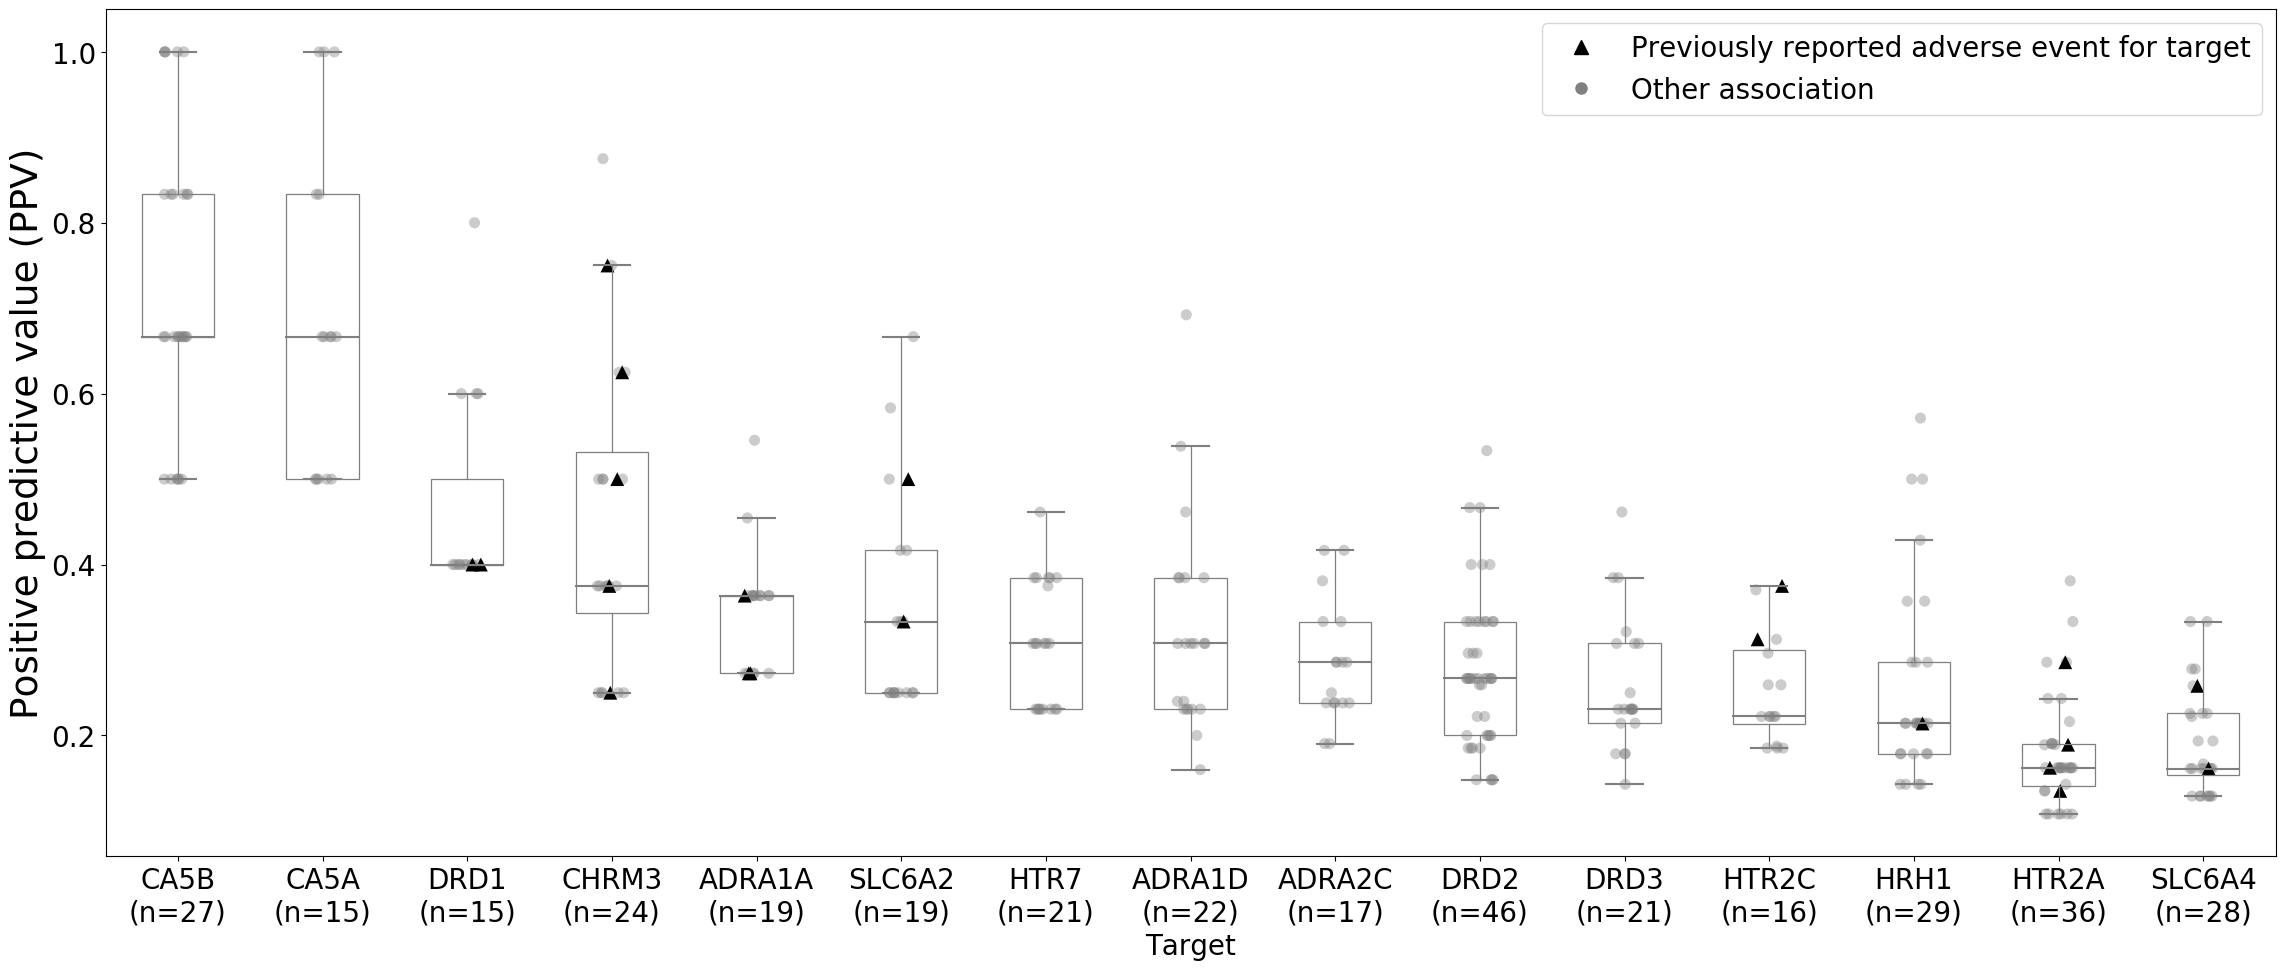

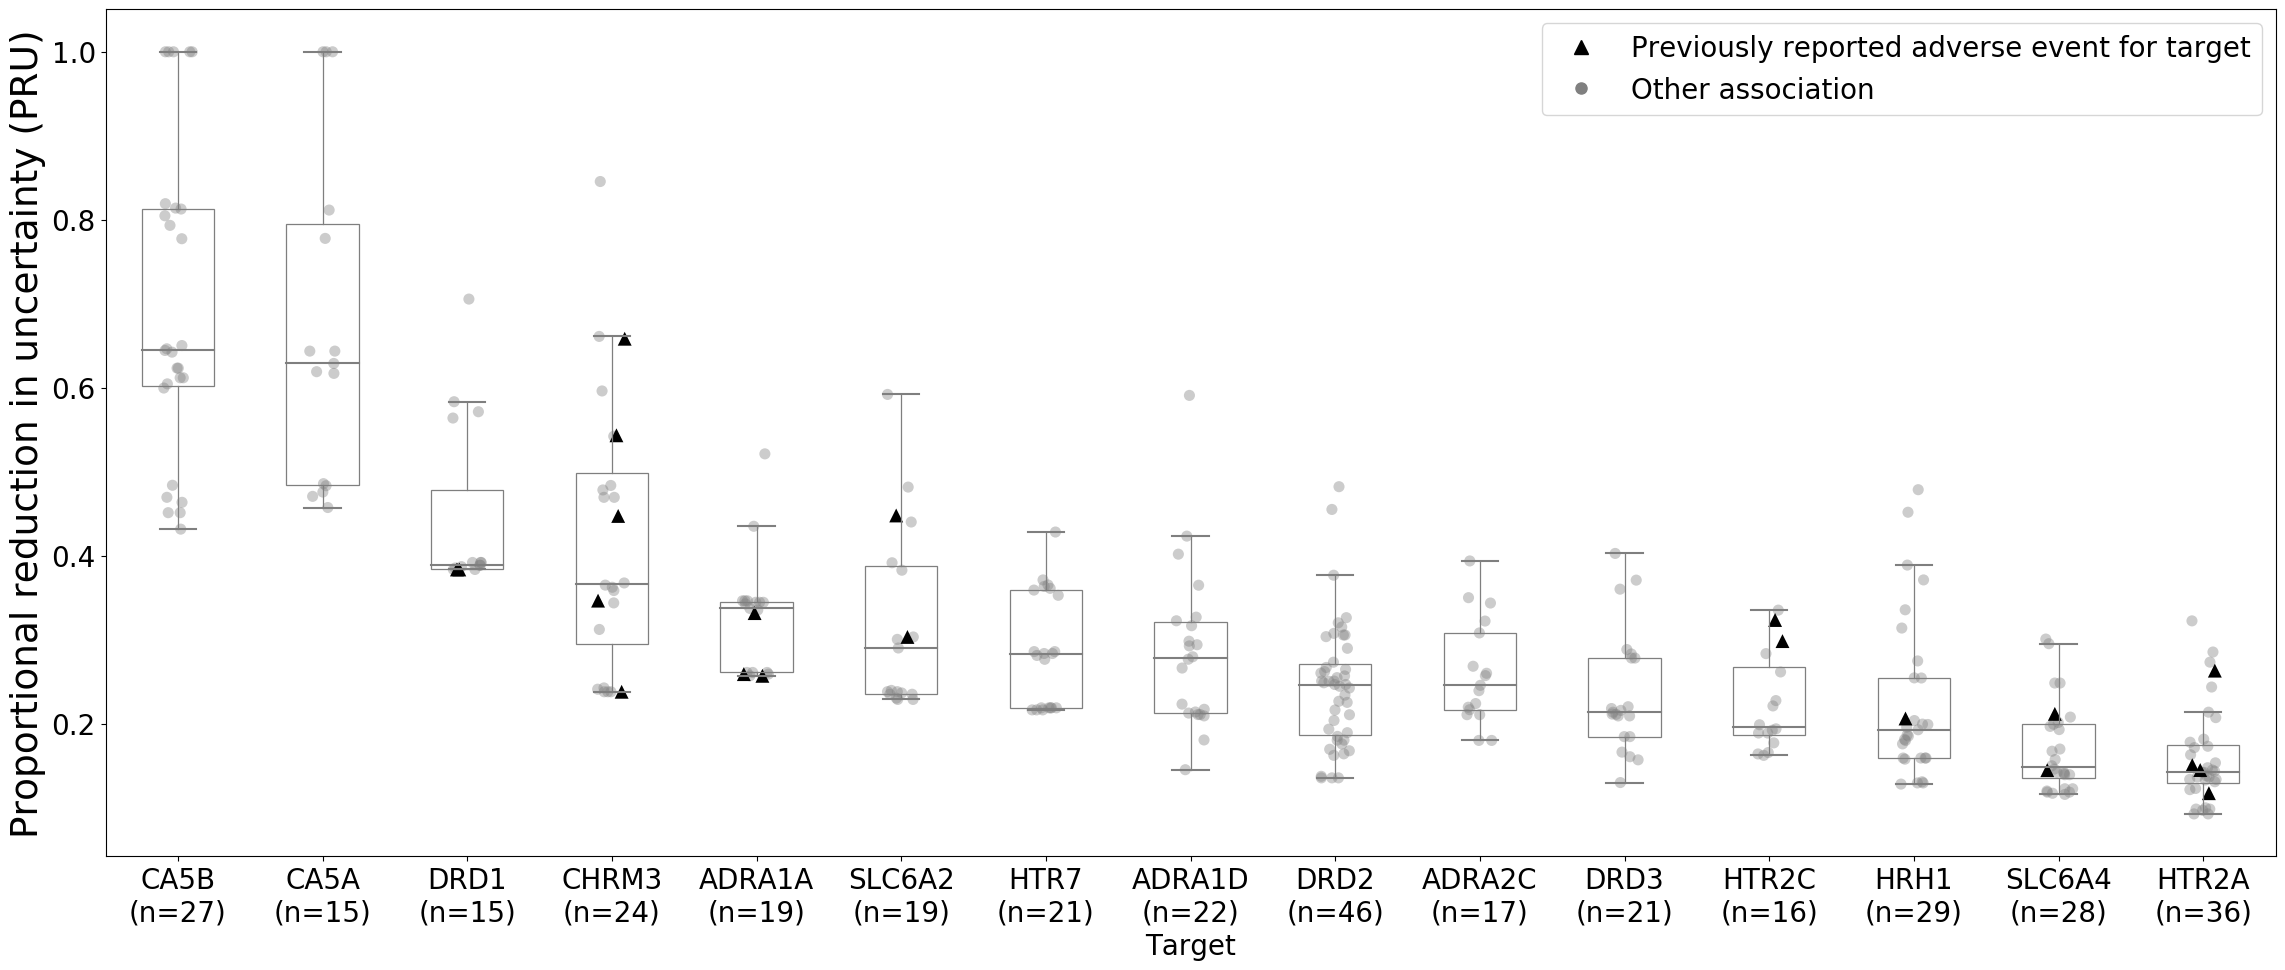

In [29]:
do_plot_ind_targets(y_variable='PPV', variable_name='Positive predictive value (PPV)')
do_plot_ind_targets(y_variable='PRU', variable_name='Proportional reduction in uncertainty (PRU)')


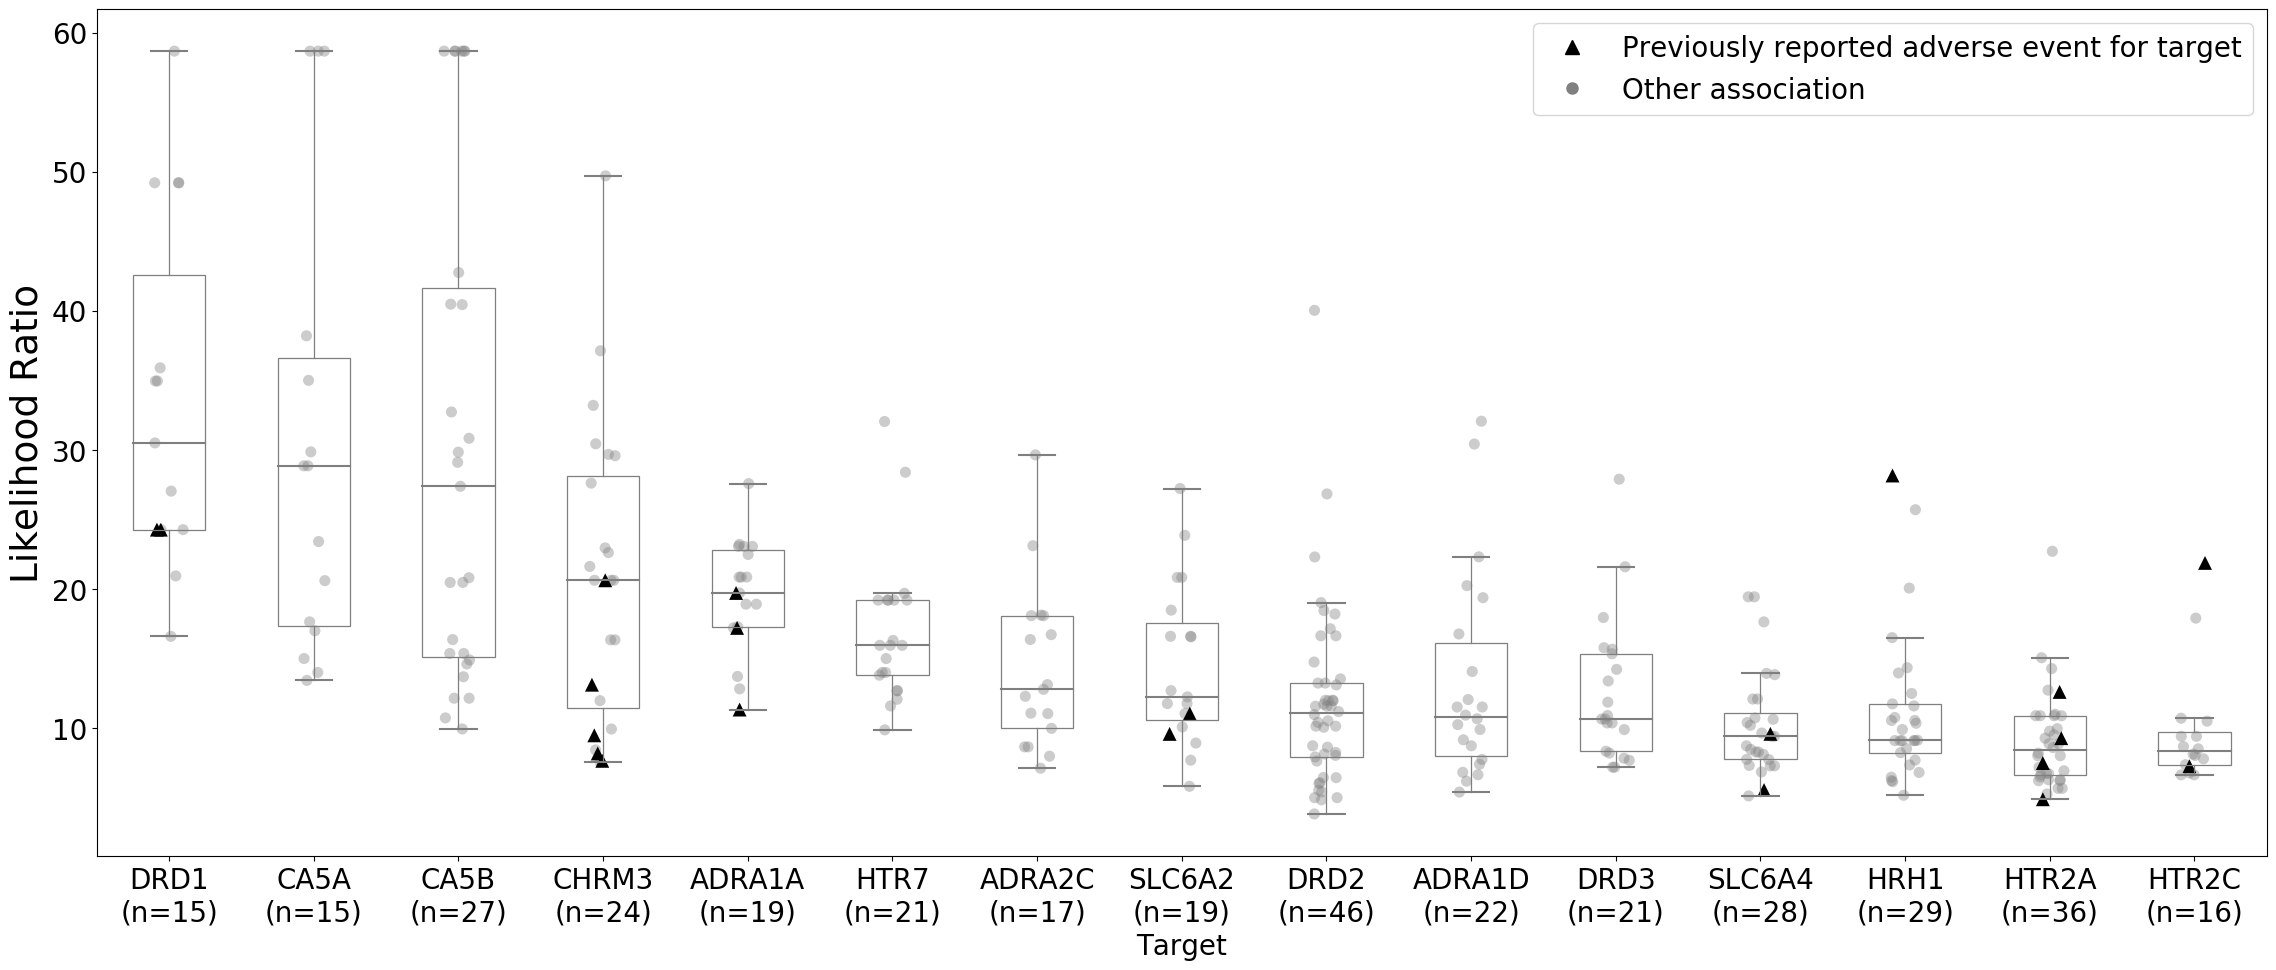

In [30]:
do_plot_ind_targets(y_variable='Likelihood Ratio', variable_name='Likelihood Ratio')

In [31]:
max(combined_sign_selected['Likelihood Ratio'])

58.66666666666666

### Violin/raincloud plots per target class


In [32]:
target_class = pd.read_csv(basedir + '/analysis/data/target_classification_all_levels_r.txt', sep='\t')

def find_integrated(x):
    if x['level_2'] == 'Not available':
        return x['level_1']
    else:
        return x['level_2']

target_class['integrated_level'] = target_class.apply(find_integrated, axis=1)

In [33]:
combined_sign_tc = combined_sign_no_inf.merge(target_class, on='accession').merge(meddra_hier_selection, left_on='Adverse Event', right_on=' Term')

def find_known(row):
    if ((row['accession'],row['HLT'])) in known_tuples:
        return 1
    else:
        return 0
    
combined_sign_tc['known association'] = combined_sign_tc.apply(find_known, axis=1)

combined_sign_known_tc = combined_sign_tc.loc[combined_sign_tc['known association']==1]

In [34]:
tcs_min_n = list(combined_sign_tc.groupby('integrated_level').count().query('accession > 5').index)

In [35]:
combined_sign_tc_min_n = combined_sign_tc.loc[combined_sign_tc['integrated_level'].isin(tcs_min_n)]

In [68]:
tcs_min_n

['Electrochemical transporter',
 'Family A G protein-coupled receptor',
 'Lyase',
 'Membrane receptor',
 'Oxidoreductase']

In [73]:
combined_sign_tc_min_n.loc[combined_sign_tc_min_n['integrated_level'].isin(tcs_min_n),['integrated_level','level_1','level_2']].drop_duplicates()

,integrated_level,level_1,level_2
0,Lyase,Enzyme,Lyase
16,Family A G protein-coupled receptor,Membrane receptor,Family A G protein-coupled receptor
124,Electrochemical transporter,Transporter,Electrochemical transporter
214,Membrane receptor,Membrane receptor,Not available
432,Oxidoreductase,Enzyme,Oxidoreductase


In [36]:
def do_target_class_plot(y_variable, variable_name):
    sorted_tcs = list(combined_sign_tc_min_n.groupby('integrated_level')[y_variable].median().sort_values(ascending=False).index)

    sorterIndex = dict(zip(sorted_tcs,range(len(sorted_tcs))))
    combined_sign_tc_min_n['Rank'] = combined_sign_tc_min_n['integrated_level'].map(sorterIndex)
    combined_sign_tc_min_n['Target class'] = combined_sign_tc_min_n['integrated_level'].apply(lambda x: x + '\n(n={})'.format(len(combined_sign_tc_min_n.loc[combined_sign_tc_min_n['integrated_level']==x,'Adverse Event'])))

    to_add = []
    for target_class in set(combined_sign_tc_min_n['integrated_level']) - set(combined_sign_known_tc['integrated_level']):
        size = str(len(combined_sign_tc_min_n.loc[combined_sign_tc_min_n['integrated_level']==target_class,'Adverse Event']))
        rank = list(combined_sign_tc_min_n.loc[combined_sign_tc_min_n['integrated_level']==target_class,'Rank'])[0]
        to_add.append({'integrated_level': target_class, 'Target class': target_class + '\n(n={})'.format(size), 'Rank': rank })

    plt.rcdefaults()
    plt.rcParams.update({'font.size': 20})

    pal = "Set2"
    dy=y_variable; dx="Target class"; ort="v"; #pal = sns.color_palette(n_colors=1)
    df = combined_sign_tc_min_n.sort_values(by='Rank')
    df_new = combined_sign_tc_min_n.loc[combined_sign_tc_min_n['known association']==0].sort_values(by='Rank')
    df_known = combined_sign_tc_min_n.loc[combined_sign_tc_min_n['known association']==1]

    df_known = df_known.append(to_add, ignore_index=True)

    f, ax = plt.subplots(figsize=(28, 11))

    ax=sns.boxplot( x = dx, y = dy, data = df, color = "lightgrey", width = .2, zorder = 10,\
                showcaps = True, boxprops = {'facecolor':'none', "zorder":10, 'linewidth':0.9},\
                showfliers=False, whiskerprops = {'linewidth':0.9, "zorder":10},\
                   saturation = 1, orient = ort)

    ax=pt.half_violinplot( x = dx, y = dy, data = df, color='lightgrey', bw = .5, cut = 0., scale = "area", width = .8, inner = None, orient = ort, linewidth=0.5)
    ax=sns.stripplot( x = dx, y = dy, data = df_new, color = 'grey', edgecolor = "white",size = 8, jitter = 1, zorder = 0, orient = ort, alpha=0.4)
    ax=sns.stripplot( x = dx, y = dy, data = df_known.sort_values(by='Rank'), color = 'black', marker='^', edgecolor = "black",
                     size = 10, jitter = 1, zorder = 0, orient = ort, alpha=0.8)
    #ax=sns.swarmplot( x = dx, y = dy, data = df_known.sort_values(by='Rank'), color = 'black', size=12)
    #ax=sns.swarmplot( x = dx, y = dy, data = df_new.sort_values(by='Rank'), color = 'grey', alpha=0.6, size=8)

    handles, labels = ax.get_legend_handles_labels()
    simArtist = plt.Line2D((0,0),(0,0), color='black', marker='^', linestyle='', ms=10, alpha=0.8)
    anyArtist = plt.Line2D((0,0),(0,0), color='grey', marker='o', linestyle='', ms=8)

    #Create legend from custom artist/label lists
    ax.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist],
              [label for i,label in enumerate(labels) if i in display]+['Previously reported association', 'Association not previously reported']
             ,loc=1 , ncol=1) #loc='upper left', bbox_to_anchor=(0, 1.1)

    ax.set_ylabel(variable_name, fontsize=27)
    y_variable_name = y_variable.replace(' ', '_')
    plt.savefig(basedir + f'/analysis/results/{combined_destination_dir}/Distributions_TargetClass_{y_variable_name}.png', bbox_inches='tight', dpi=150)
    plt.close()

In [37]:
do_target_class_plot(y_variable='PPV', variable_name='Positive predictive value (PPV)')
do_target_class_plot(y_variable='PRU', variable_name='Proportional reduction in uncertainty (PRU)')
do_target_class_plot(y_variable='Likelihood Ratio', variable_name='Likelihood Ratio')

/scratch/ias41/envs/raincloud/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/scratch/ias41/envs/raincloud/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/scratch/ias41/envs/raincloud/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

In [77]:
df_known.sort_values(by='PPV').head(10)

,pref_name,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,corrected p-value,PPV,ae_prevalence,dataset,accession,PRU,improvement_over_prevalence,specificity,Term,HLT,SOC,PT,known association,Rank,Target
10,Serotonin 2a (5-HT2a) receptor,636.0,13.0,0.384615,623.0,0.051364,37.0,599.0,DROOLING,7.487981,0.030912,0.135135,0.020440,FAERS,P28223,0.117088,0.114695,0.948636,DROOLING,NEUROLOGICAL SIGNS AND SYMPTOMS NEC,Nervous system disorders,Drooling,1.0,13,HTR2A\n(n=36)
4,Serotonin transporter,661.0,13.0,0.384615,648.0,0.040123,31.0,630.0,AGITATION NEONATAL,9.585799,0.026653,0.161290,0.019667,FAERS,P31645,0.144464,0.141623,0.959877,AGITATION NEONATAL,NEUROLOGICAL SIGNS AND SYMPTOMS NEC,Nervous system disorders,Agitation neonatal,1.0,14,SLC6A4\n(n=28)
3,Serotonin 2a (5-HT2a) receptor,636.0,13.0,0.461538,623.0,0.049759,37.0,599.0,GRIMACING,9.275434,0.009738,0.162162,0.020440,FAERS,P28223,0.144679,0.141722,0.950241,GRIMACING,NEUROLOGICAL SIGNS AND SYMPTOMS NEC,Nervous system disorders,Grimacing,1.0,13,HTR2A\n(n=36)
8,Serotonin 2a (5-HT2a) receptor,636.0,29.0,0.241379,607.0,0.049423,37.0,599.0,NEUROLEPTIC MALIGNANT SYNDROME,4.883908,0.042450,0.189189,0.045597,FAERS,P28223,0.150452,0.143592,0.950577,NEUROLEPTIC MALIGNANT SYNDROME,MUSCLE TONE ABNORMAL,Nervous system disorders,Neuroleptic malignant syndrome,1.0,13,HTR2A\n(n=36)
11,Histamine H1 receptor,522.0,5.0,0.600000,517.0,0.021277,14.0,508.0,PROTRUSION TONGUE,28.200000,0.005594,0.214286,0.009579,SIDER,P35367,0.206687,0.204707,0.978723,PROTRUSION TONGUE,TONGUE SIGNS AND SYMPTOMS,Gastrointestinal disorders,Protrusion tongue,1.0,12,HRH1\n(n=29)
15,Muscarinic acetylcholine receptor M3,503.0,8.0,0.250000,495.0,0.012121,8.0,495.0,MIOSIS,20.625000,0.048000,0.250000,0.015905,SIDER,P20309,0.237879,0.234095,0.987879,MIOSIS,PUPIL DISORDERS,Eye disorders,Miosis,1.0,3,CHRM3\n(n=24)
5,Serotonin transporter,661.0,39.0,0.205128,622.0,0.036977,31.0,630.0,MYOCLONUS,5.547380,0.028847,0.258065,0.059002,FAERS,P31645,0.211544,0.199063,0.963023,MYOCLONUS,NEUROLOGICAL SIGNS AND SYMPTOMS NEC,Nervous system disorders,Myoclonus,1.0,14,SLC6A4\n(n=28)
0,Alpha-1a adrenergic receptor,375.0,7.0,0.428571,368.0,0.021739,11.0,364.0,INSULIN RESISTANCE,19.714286,0.032562,0.272727,0.018667,FAERS,P35348,0.258893,0.254061,0.978261,INSULIN RESISTANCE,HYPERGLYCAEMIC CONDITIONS NEC,Metabolism and nutrition disorders,Insulin resistance,1.0,4,ADRA1A\n(n=19)
2,Alpha-1a adrenergic receptor,375.0,8.0,0.375000,367.0,0.021798,11.0,364.0,GRIMACING,17.203125,0.044790,0.272727,0.021333,FAERS,P35348,0.256874,0.251394,0.978202,GRIMACING,NEUROLOGICAL SIGNS AND SYMPTOMS NEC,Nervous system disorders,Grimacing,1.0,4,ADRA1A\n(n=19)
9,Serotonin 2a (5-HT2a) receptor,520.0,16.0,0.375000,504.0,0.029762,21.0,499.0,NEUROLEPTIC MALIGNANT SYNDROME,12.600000,0.001698,0.285714,0.030769,SIDER,P28223,0.263039,0.254945,0.970238,NEUROLEPTIC MALIGNANT SYNDROME,MUSCLE TONE ABNORMAL,Nervous system disorders,Neuroleptic malignant syndrome,1.0,13,HTR2A\n(n=36)


In [87]:
combined_sign_tc_min_n.groupby('Target class')['PPV'].describe()

,count,mean,std,min,25%,50%,75%,max
Target class,,,,,,,,
Electrochemical transporter\n(n=48),48.0,0.257333,0.121144,0.129032,0.161290,0.250000,0.308333,0.666667
Family A G protein-coupled receptor\n(n=383),383.0,0.325671,0.149567,0.108108,0.230769,0.285714,0.375000,1.000000
Lyase\n(n=82),82.0,0.592438,0.217574,0.214286,0.446970,0.595960,0.666667,1.000000
Membrane receptor\n(n=8),8.0,0.273438,0.074233,0.187500,0.234375,0.250000,0.328125,0.375000
Oxidoreductase\n(n=12),12.0,0.407828,0.172779,0.250000,0.318182,0.348485,0.454545,0.818182


### Violin/raincloud plots per SOC


In [38]:
socs_min_n = list(combined_sign_tc.groupby('SOC').count().query('pref_name > 5').index)

In [39]:
combined_sign_soc_min_n = combined_sign_tc.loc[combined_sign_tc['SOC'].isin(socs_min_n)]

In [80]:
combined_sign_soc_min_n.groupby('SOC')['PPV'].describe()

,count,mean,std,min,25%,50%,75%,max
SOC,,,,,,,,
Blood and lymphatic system disorders,28.0,0.593044,0.255689,0.214286,0.375000,0.563492,0.833333,1.000000
Cardiac disorders,15.0,0.301065,0.120674,0.162162,0.218254,0.250000,0.400641,0.538462
Eye disorders,30.0,0.297822,0.086556,0.129032,0.235577,0.279221,0.375000,0.500000
Gastrointestinal disorders,64.0,0.362408,0.189667,0.142857,0.230769,0.285714,0.400000,0.857143
General disorders and administration site conditions,24.0,0.296862,0.146371,0.142857,0.185185,0.250000,0.343750,0.692308
Hepatobiliary disorders,7.0,0.478355,0.209555,0.272727,0.333333,0.363636,0.606061,0.833333
"Injury, poisoning and procedural complications",10.0,0.273397,0.077694,0.129032,0.218614,0.285714,0.315559,0.380952
Investigations,8.0,0.308316,0.183039,0.108108,0.213745,0.234525,0.347222,0.666667
Metabolism and nutrition disorders,73.0,0.350100,0.190034,0.108108,0.189189,0.333333,0.428571,1.000000


In [40]:
combined_sign_known_soc = combined_sign_soc_min_n.loc[combined_sign_soc_min_n['known association']==1]

In [41]:
def do_soc_class_plot(y_variable, variable_name):
    sorted_socs = list(combined_sign_soc_min_n.groupby('SOC')[y_variable].median().sort_values(ascending=False).index)

    sorterIndex = dict(zip(sorted_socs,range(len(sorted_socs))))
    combined_sign_soc_min_n['Rank'] = combined_sign_soc_min_n['SOC'].map(sorterIndex)
    combined_sign_soc_min_n['SOC class'] = combined_sign_soc_min_n['SOC'].apply(lambda x: x + ' (n={})'.format(len(combined_sign_soc_min_n.loc[combined_sign_soc_min_n['SOC']==x,'Adverse Event'])))

    to_add = []
    for soc_class in set(combined_sign_soc_min_n['SOC']) - set(combined_sign_known_soc['SOC']):
        size = str(len(combined_sign_soc_min_n.loc[combined_sign_soc_min_n['SOC']==soc_class,'Adverse Event']))
        rank = list(combined_sign_soc_min_n.loc[combined_sign_soc_min_n['SOC']==soc_class,'Rank'])[0]
        to_add.append({'SOC': soc_class, 'SOC class': soc_class + ' (n={})'.format(size), 'Rank': rank })

    plt.rcdefaults()
    plt.rcParams.update({'font.size': 20})

    pal = "Set2"
    dy=y_variable; dx="SOC class"; ort="v"; #pal = sns.color_palette(n_colors=1)
    df = combined_sign_soc_min_n.sort_values(by='Rank')
    df_new = combined_sign_soc_min_n.loc[combined_sign_soc_min_n['known association']==0].sort_values(by='Rank')
    df_known = combined_sign_soc_min_n.loc[combined_sign_soc_min_n['known association']==1]
    if len(to_add) > 0:
        df_known = df_known.append(to_add, ignore_index=True)

    f, ax = plt.subplots(figsize=(28, 11))

    ax=sns.boxplot( x = dx, y = dy, data = df, color = "lightgrey", width = .3, zorder = 10,\
                showcaps = True, boxprops = {'facecolor':'none', "zorder":10, 'linewidth':0.9},\
                showfliers=False, whiskerprops = {'linewidth':0.9, "zorder":10},\
                   saturation = 1, orient = ort)

#    ax=pt.half_violinplot( x = dx, y = dy, data = df, color='lightgrey', bw = .3, cut = 0., scale = "area", width = .8, inner = None, orient = ort, linewidth=0.5)
    ax=sns.stripplot( x = dx, y = dy, data = df_new.sort_values(by='Rank'), color = 'grey', edgecolor = "white",size = 8, jitter = 1, zorder = 0, orient = ort, alpha=0.4)
    ax=sns.stripplot( x = dx, y = dy, data = df_known.sort_values(by='Rank'), color = 'black', marker='^', edgecolor = "black",
                     size = 10, jitter = 1, zorder = 0, orient = ort, alpha=0.8)
    #ax=sns.swarmplot( x = dx, y = dy, data = df_new.sort_values(by='Rank'), color = 'grey', alpha=0.6, size=8, orient=ort)

    handles, labels = ax.get_legend_handles_labels()
    simArtist = plt.Line2D((0,0),(0,0), color='black', marker='^', linestyle='', ms=10, alpha=0.8)
    anyArtist = plt.Line2D((0,0),(0,0), color='grey', marker='o', linestyle='', ms=8)

    #Create legend from custom artist/label lists
    ax.legend([handle for i,handle in enumerate(handles) if i in display]+[simArtist,anyArtist],
              [label for i,label in enumerate(labels) if i in display]+['Previously reported association', 'Association not previously reported']
             ,loc=1 , ncol=1) #loc='upper left', bbox_to_anchor=(0, 1.1)

    ax.set_ylabel(variable_name, fontsize=27)
    ax.set_xlabel('System Organ Class', fontsize=27)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    y_variable_name = y_variable.replace(' ', '_')
    plt.savefig(basedir + f'/analysis/results/{combined_destination_dir}/Distributions_SOC_{y_variable_name}.png', bbox_inches='tight', dpi=150)

/scratch/ias41/envs/raincloud/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/scratch/ias41/envs/raincloud/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/scratch/ias41/envs/raincloud/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

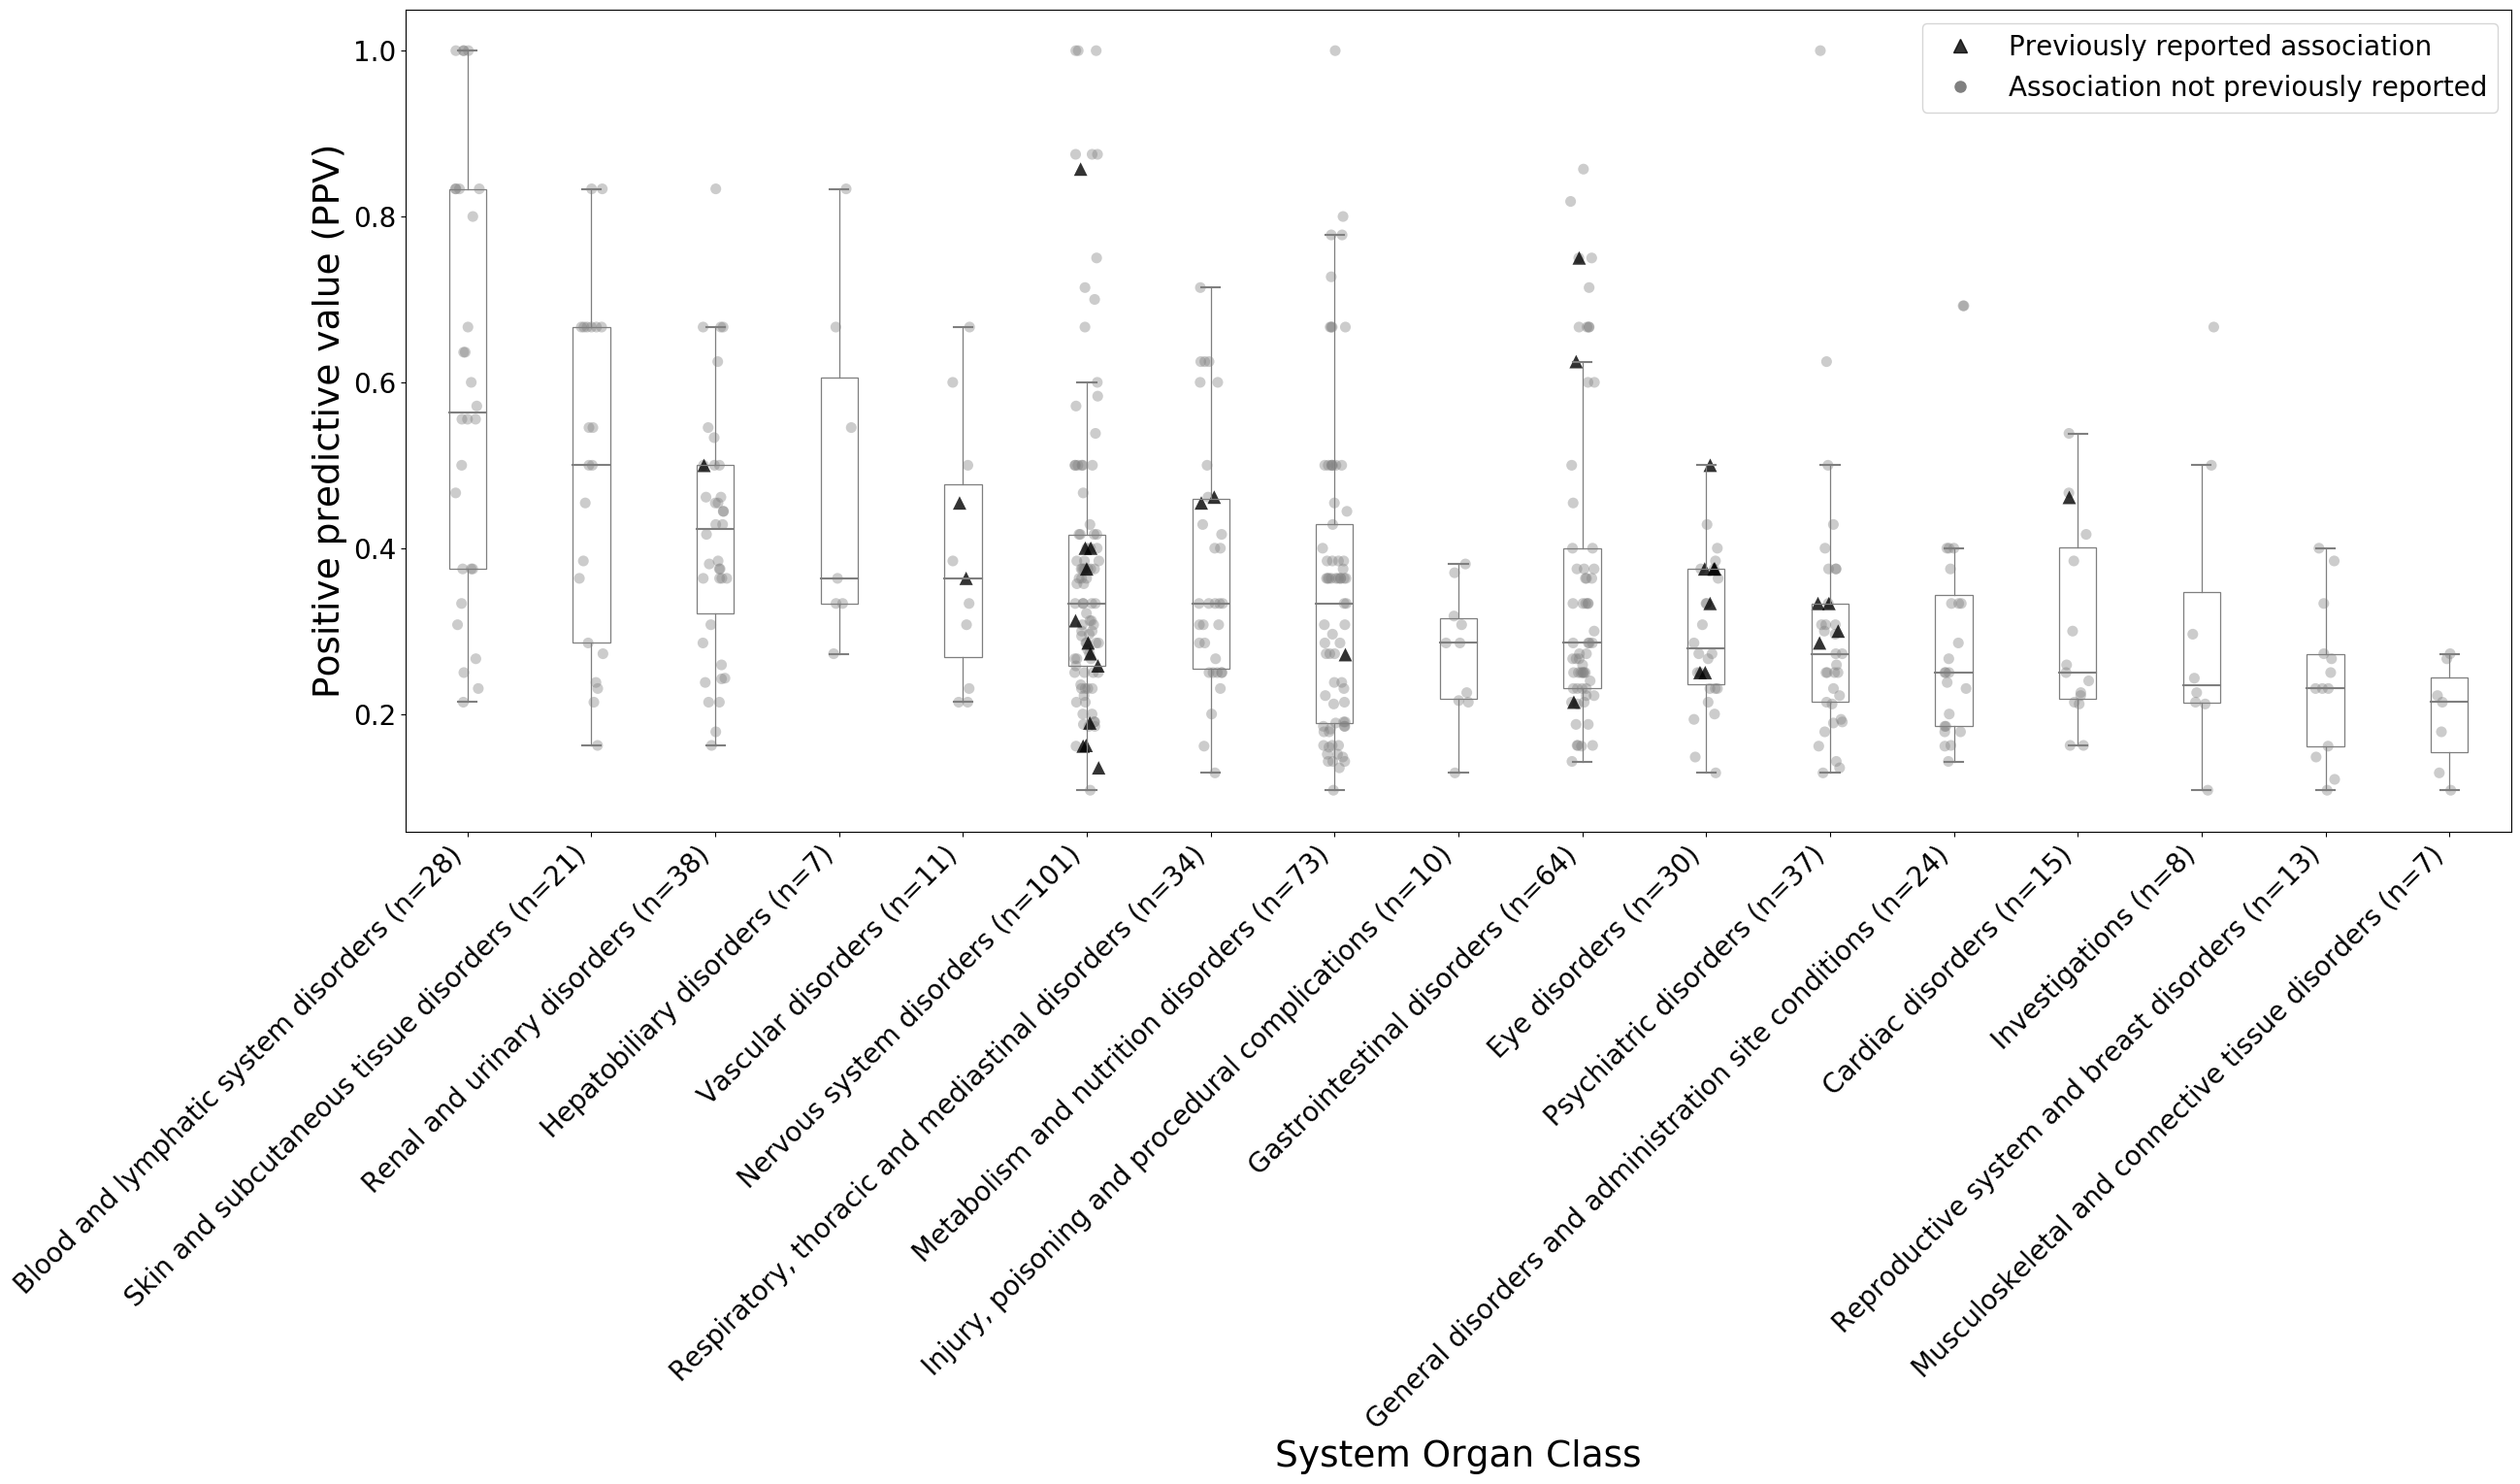

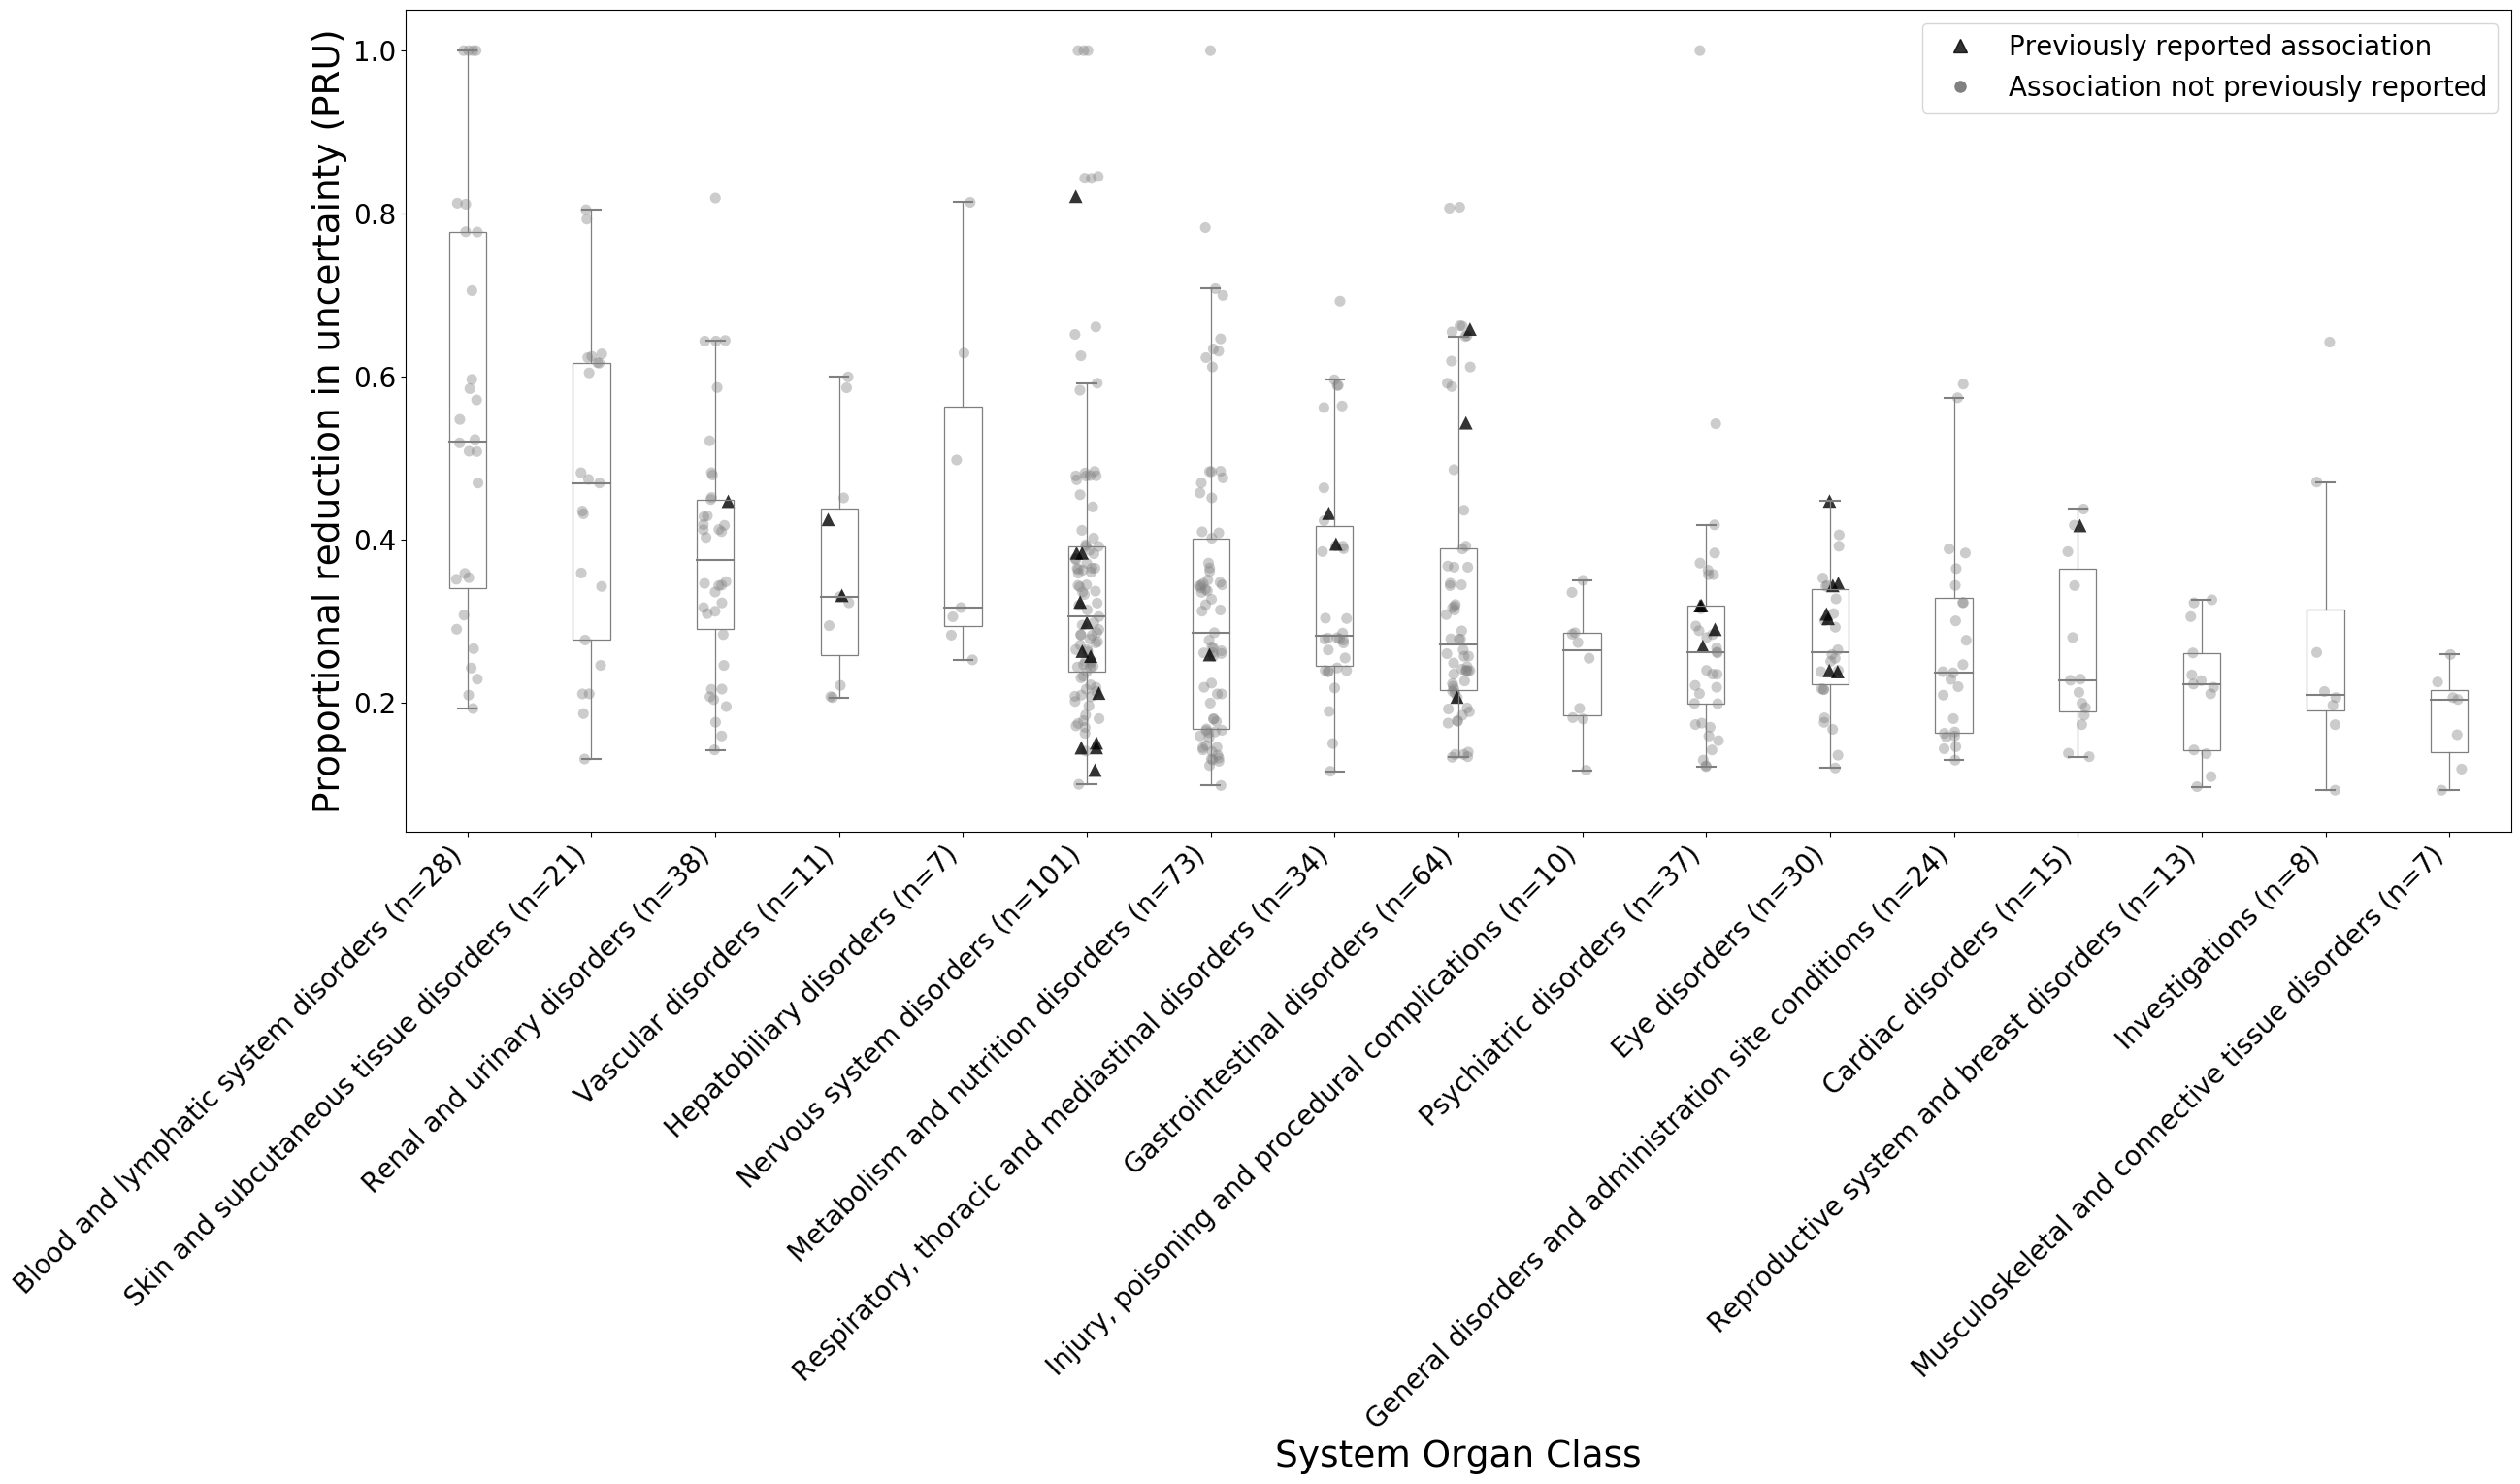

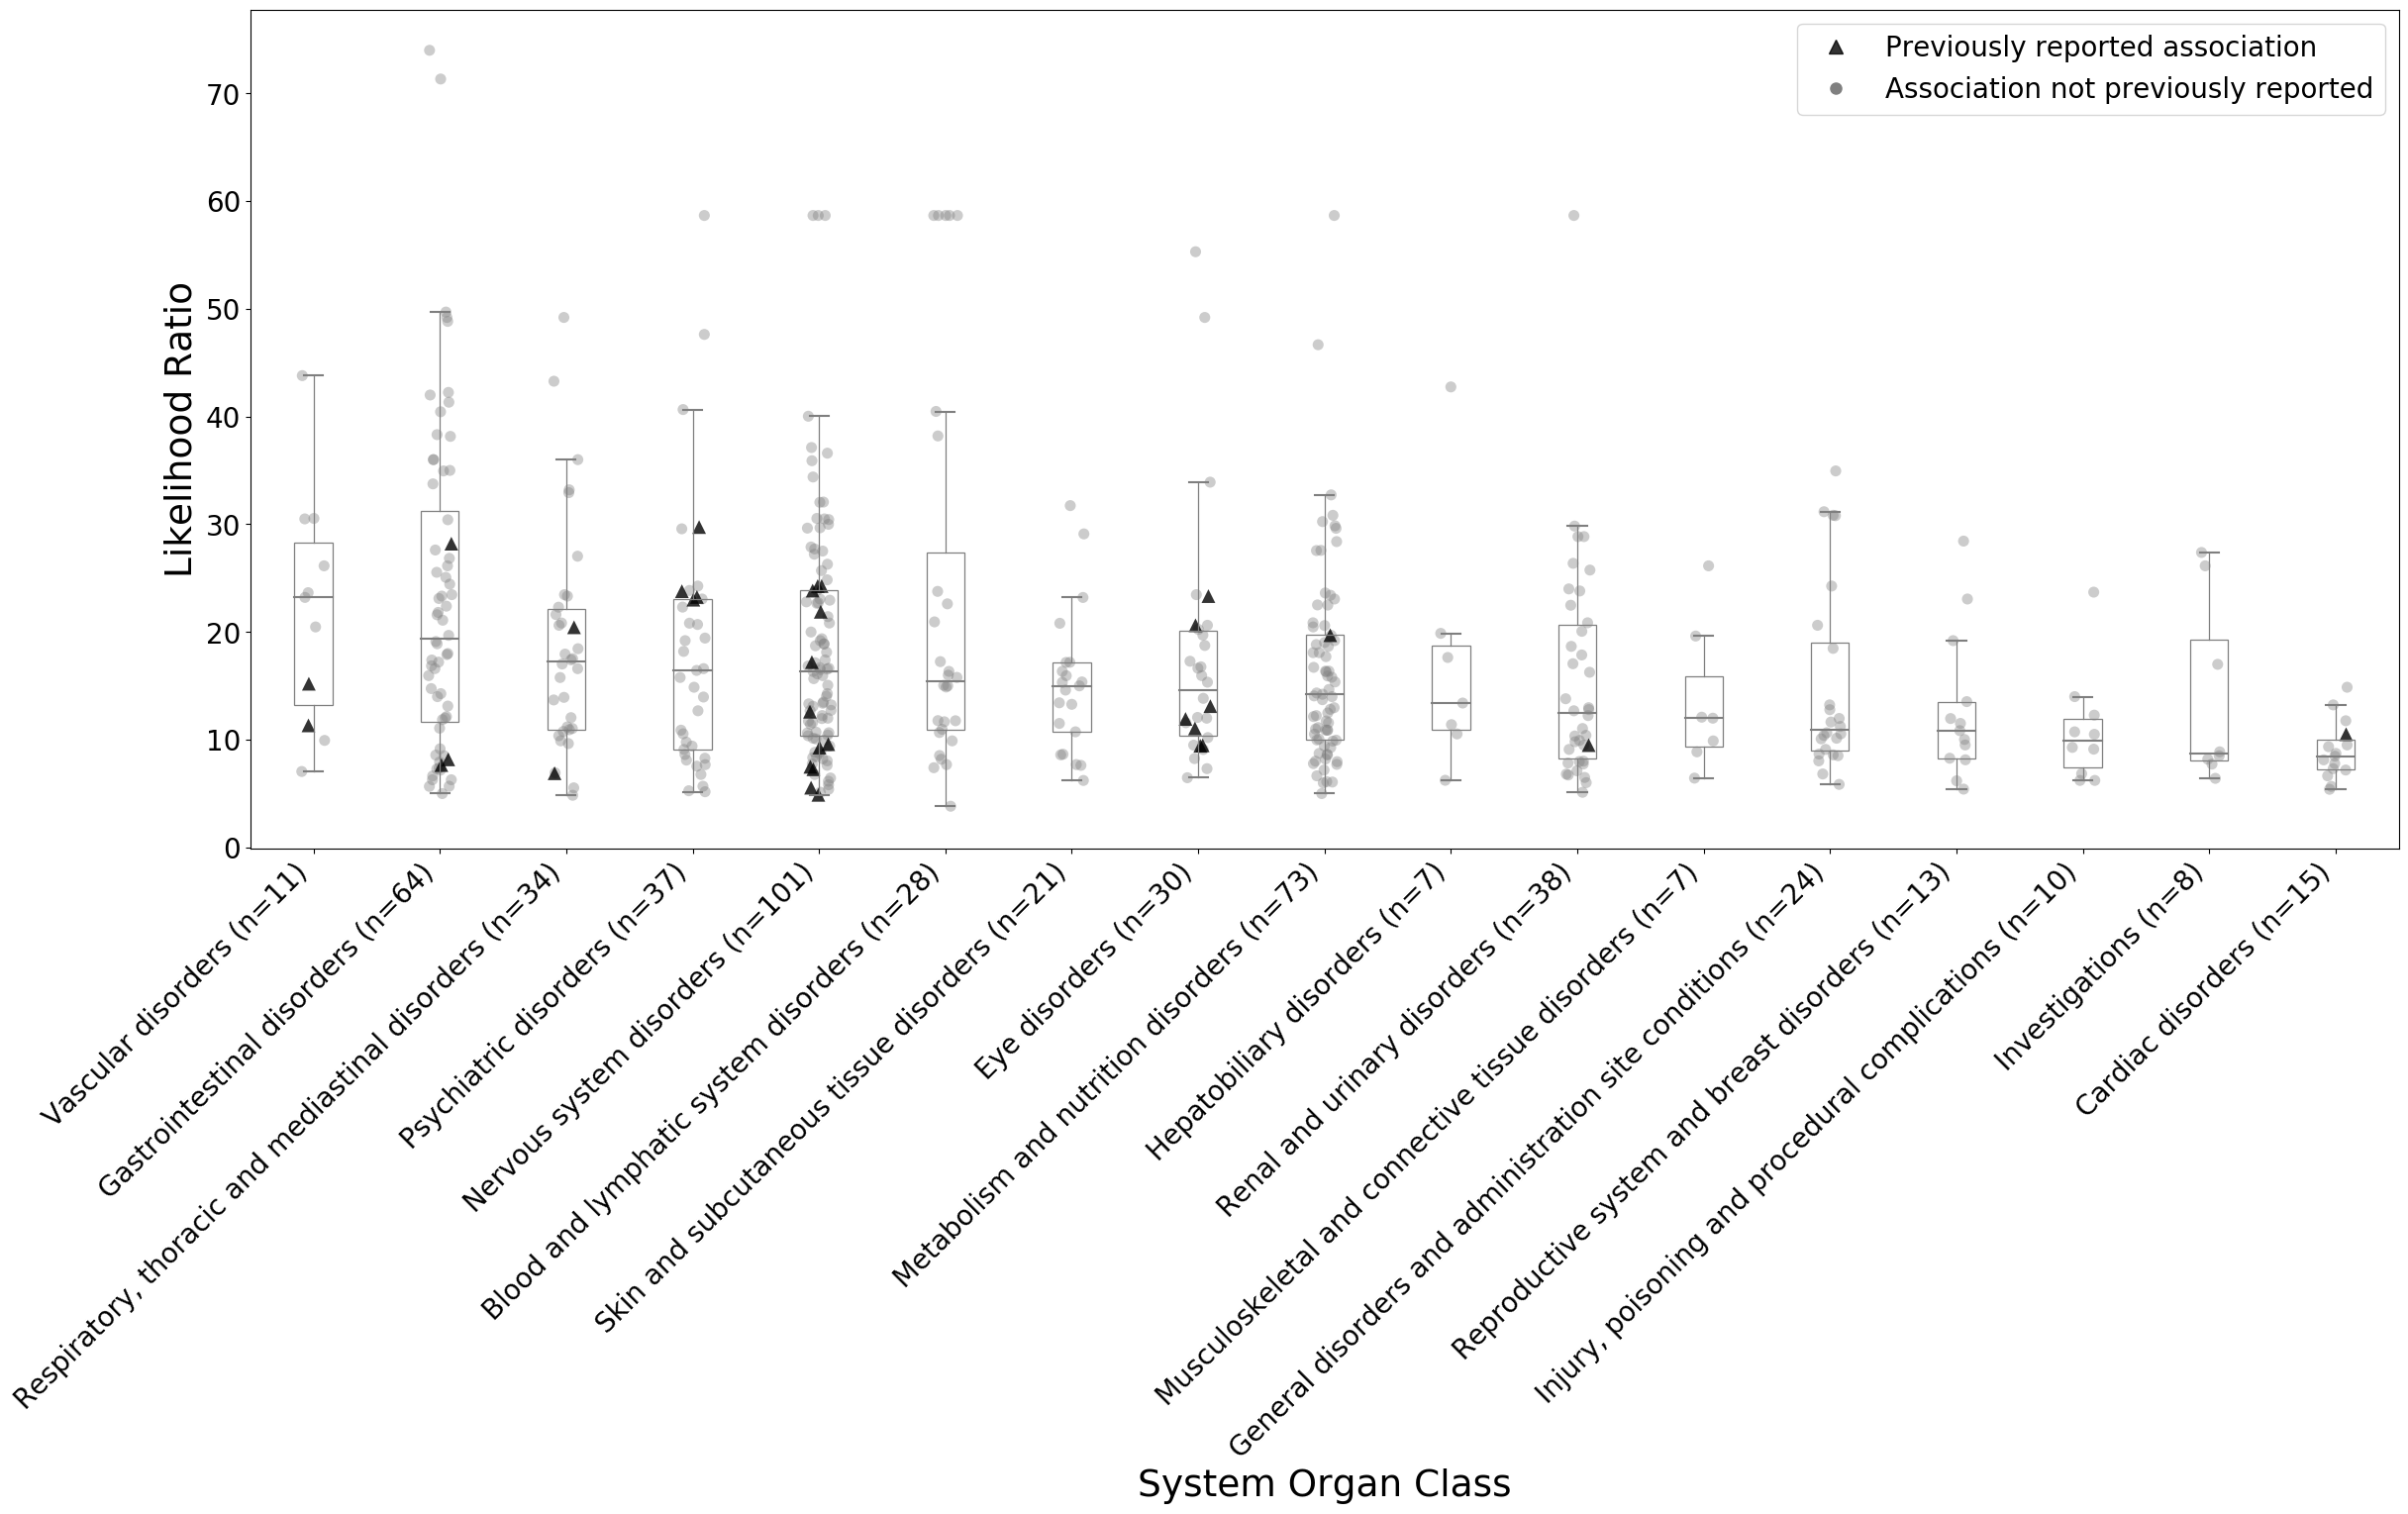

In [42]:
do_soc_class_plot(y_variable='PPV', variable_name='Positive predictive value (PPV)')
do_soc_class_plot(y_variable='PRU', variable_name='Proportional reduction in uncertainty (PRU)')
do_soc_class_plot(y_variable='Likelihood Ratio', variable_name='Likelihood Ratio')

### Raincloud

In [43]:
combined_sign_no_inf.columns

Index(['pref_name', 'nr compounds', 'nr compounds with AE', 'ae_hit_rate',
       'nr compounds without AE', 'nae_hit_rate', 'nr compounds active',
       'nr compounds inactive', 'Adverse Event', 'Likelihood Ratio',
       'corrected p-value', 'PPV', 'ae_prevalence', 'dataset', 'accession',
       'PRU', 'improvement_over_prevalence', 'specificity'],
      dtype='object')

In [44]:
raincloud_combined_sign_no_inf = combined_sign_no_inf.copy()
len_faers = len(raincloud_combined_sign_no_inf.loc[raincloud_combined_sign_no_inf['dataset']=='FAERS'])
len_sider = len(raincloud_combined_sign_no_inf.loc[raincloud_combined_sign_no_inf['dataset']=='SIDER'])
raincloud_combined_sign_no_inf['Dataset'] = raincloud_combined_sign_no_inf['dataset'].apply(lambda x: x + f' (n={len_faers} significant target-AE associations)' if x == 'FAERS' else x + f' (n={len_sider} significant target-AE associations)')

In [45]:
raincloud_combined_sign_no_inf.head()

,pref_name,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,corrected p-value,PPV,ae_prevalence,dataset,accession,PRU,improvement_over_prevalence,specificity,Dataset
0,Carbonic anhydrase II,678,7,0.428571,671,0.016393,14.0,664.0,TOTAL LUNG CAPACITY DECREASED,26.142857,0.044123,0.214286,0.010324,FAERS,P00918,0.206089,0.203961,0.983607,FAERS (n=224 significant target-AE associations)
1,Carbonic anhydrase II,678,7,0.428571,671,0.016393,14.0,664.0,AORTIC ATHEROSCLEROSIS,26.142857,0.044123,0.214286,0.010324,FAERS,P00918,0.206089,0.203961,0.983607,FAERS (n=224 significant target-AE associations)
2,Carbonic anhydrase II,678,7,0.428571,671,0.016393,14.0,664.0,INTERVERTEBRAL DISC COMPRESSION,26.142857,0.044123,0.214286,0.010324,FAERS,P00918,0.206089,0.203961,0.983607,FAERS (n=224 significant target-AE associations)
3,Carbonic anhydrase II,678,6,0.500000,672,0.016369,14.0,664.0,SIMPLE PARTIAL SEIZURES,30.545455,0.044123,0.214286,0.008850,FAERS,P00918,0.207270,0.205436,0.983631,FAERS (n=224 significant target-AE associations)
4,Carbonic anhydrase II,678,7,0.428571,671,0.016393,14.0,664.0,LIP HAEMORRHAGE,26.142857,0.044123,0.214286,0.010324,FAERS,P00918,0.206089,0.203961,0.983607,FAERS (n=224 significant target-AE associations)


In [46]:
df1 = raincloud_combined_sign_no_inf.copy()
df1['values'] = df1['PPV']
df1['variable_type'] = 'PPV'
df2 = raincloud_combined_sign_no_inf.copy()
df2['values'] = df2['PRU']
df2['variable_type'] = 'PRU'
df3 = raincloud_combined_sign_no_inf.copy()
df3['values'] = df3['ae_prevalence']
df3['variable_type'] = 'Prevalence'
df_reformatted = pd.concat([df1, df2, df3])

In [47]:
df_reformatted.tail()

,pref_name,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,corrected p-value,PPV,ae_prevalence,dataset,accession,PRU,improvement_over_prevalence,specificity,Dataset,values,variable_type
310,Alpha-1d adrenergic receptor,512,22,0.181818,490,0.018367,13.0,499.0,OROPHARYNGEAL PAIN,9.898990,0.033969,0.307692,0.042969,SIDER,P25100,0.276609,0.264724,0.981633,SIDER (n=315 significant target-AE associations),0.042969,Prevalence
311,Alpha-1d adrenergic receptor,512,20,0.200000,492,0.018293,13.0,499.0,OROPHARYNGEAL DISCOMFORT,10.933333,0.025888,0.307692,0.039062,SIDER,P25100,0.279550,0.268630,0.981707,SIDER (n=315 significant target-AE associations),0.039062,Prevalence
312,Alpha-1d adrenergic receptor,512,127,0.070866,385,0.010390,13.0,499.0,OEDEMA,6.820866,0.025888,0.692308,0.248047,SIDER,P25100,0.590809,0.444261,0.989610,SIDER (n=315 significant target-AE associations),0.248047,Prevalence
313,Alpha-1d adrenergic receptor,512,117,0.068376,395,0.012658,13.0,499.0,LOSS OF CONSCIOUSNESS,5.401709,0.045528,0.538462,0.228516,SIDER,P25100,0.401753,0.309946,0.987342,SIDER (n=315 significant target-AE associations),0.228516,Prevalence
314,Alpha-1d adrenergic receptor,512,13,0.230769,499,0.020040,13.0,499.0,PIGMENTATION DISORDER,11.515385,0.045528,0.230769,0.025391,SIDER,P25100,0.210729,0.205379,0.979960,SIDER (n=315 significant target-AE associations),0.025391,Prevalence


In [48]:
df_lr = raincloud_combined_sign_no_inf.copy()
df_lr['values'] = df_lr['Likelihood Ratio']
df_lr['variable_type'] = 'Likelihood Ratio'

In [49]:
raincloud_combined_sign_no_inf.head()

,pref_name,nr compounds,nr compounds with AE,ae_hit_rate,nr compounds without AE,nae_hit_rate,nr compounds active,nr compounds inactive,Adverse Event,Likelihood Ratio,corrected p-value,PPV,ae_prevalence,dataset,accession,PRU,improvement_over_prevalence,specificity,Dataset
0,Carbonic anhydrase II,678,7,0.428571,671,0.016393,14.0,664.0,TOTAL LUNG CAPACITY DECREASED,26.142857,0.044123,0.214286,0.010324,FAERS,P00918,0.206089,0.203961,0.983607,FAERS (n=224 significant target-AE associations)
1,Carbonic anhydrase II,678,7,0.428571,671,0.016393,14.0,664.0,AORTIC ATHEROSCLEROSIS,26.142857,0.044123,0.214286,0.010324,FAERS,P00918,0.206089,0.203961,0.983607,FAERS (n=224 significant target-AE associations)
2,Carbonic anhydrase II,678,7,0.428571,671,0.016393,14.0,664.0,INTERVERTEBRAL DISC COMPRESSION,26.142857,0.044123,0.214286,0.010324,FAERS,P00918,0.206089,0.203961,0.983607,FAERS (n=224 significant target-AE associations)
3,Carbonic anhydrase II,678,6,0.500000,672,0.016369,14.0,664.0,SIMPLE PARTIAL SEIZURES,30.545455,0.044123,0.214286,0.008850,FAERS,P00918,0.207270,0.205436,0.983631,FAERS (n=224 significant target-AE associations)
4,Carbonic anhydrase II,678,7,0.428571,671,0.016393,14.0,664.0,LIP HAEMORRHAGE,26.142857,0.044123,0.214286,0.010324,FAERS,P00918,0.206089,0.203961,0.983607,FAERS (n=224 significant target-AE associations)


In [50]:
df_reformatted2 = pd.concat([df1, df2])

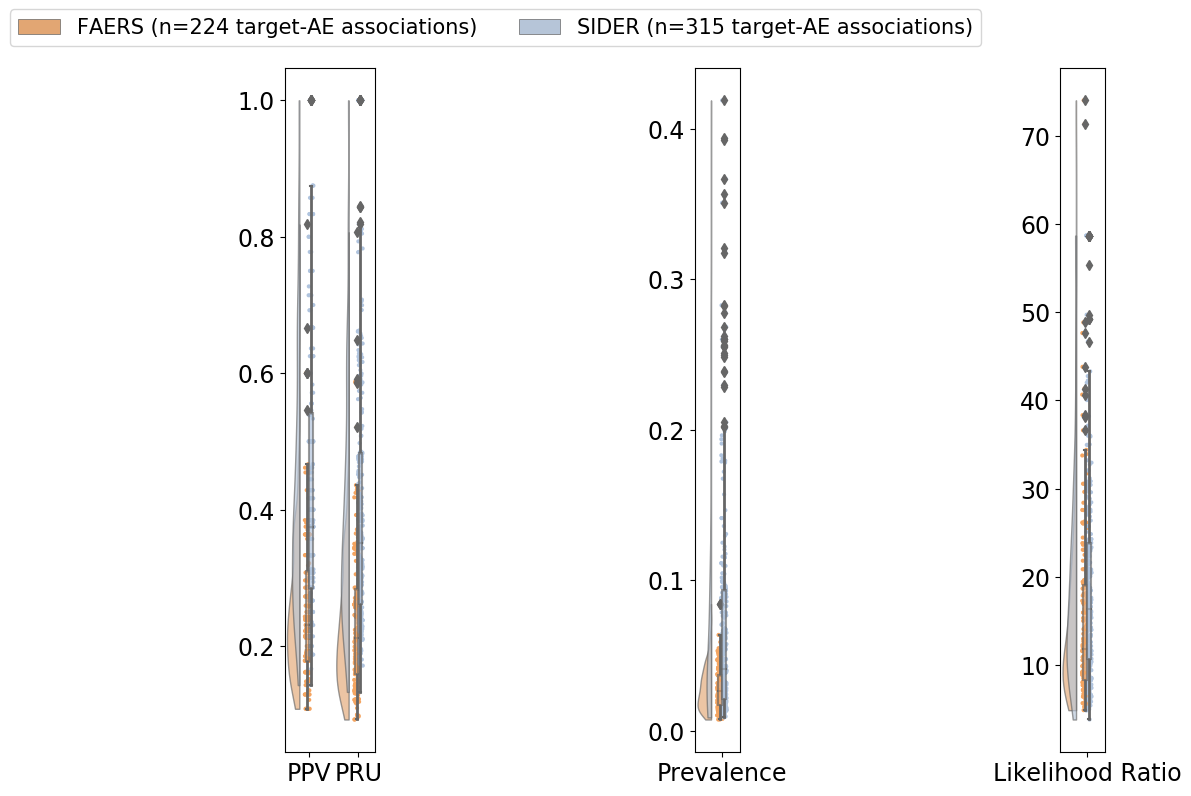

In [139]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,8), gridspec_kw={'width_ratios': [2,1,1]})
plt.rcParams.update({'font.size': 17})
#f, ax = plt.subplots(figsize=(12, 5))
my_pal = ['sandybrown', 'lightsteelblue']
ax=pt.RainCloud(y='values', x='variable_type', hue = 'Dataset', data = df_reformatted2, palette = my_pal, bw = .3,
                 width_viol = .5, ax = ax1, orient = 'v' , alpha = .65, dodge = True)
ax=pt.RainCloud(y='values', x='variable_type', hue = 'Dataset', data = df3, palette = my_pal, bw = .3,
                 width_viol = .5, ax = ax2, orient = 'v' , alpha = .65, dodge = True)
ax=pt.RainCloud(y='values', x='variable_type', hue = 'Dataset', data = df_lr, palette = my_pal, bw = .3,
                 width_viol = .5, ax = ax3, orient = 'v' , alpha = .65, dodge = True)

f.tight_layout()

ax3.set_xlabel('')
ax3.set_ylabel('')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax2.set_xlabel('')
ax2.set_ylabel('')

ax1.legend().set_visible(False)
ax2.legend().set_visible(False)
ax3.legend().set_visible(False)
#ax3.legend(bbox_to_anchor=(-0.25, 1.12), ncol=2, fontsize=15)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=15, bbox_to_anchor=(-1.5, 1.1), ncol=2)

#plt.savefig(basedir + f'/analysis/results/{combined_destination_dir}/Perf_metrics_raincloud.png', bbox_inches='tight', dpi=150)

In [82]:
ppv_df = raincloud_combined_sign_no_inf.copy()
ppv_df['values'] = ppv_df['PPV']
ppv_df['variable_type'] = 'Positive predictive\nvalue (PPV)'
pru_df = raincloud_combined_sign_no_inf.copy()
pru_df['values'] = df2['PRU']
pru_df['variable_type'] = 'Proportional reduction\nin uncertainty (PRU)'
improv_df = raincloud_combined_sign_no_inf.copy()
improv_df['values'] = df3['improvement_over_prevalence']
improv_df['variable_type'] = 'Value-added\nPPV'
ppv_etc_df = pd.concat([ppv_df, pru_df, improv_df])

In [83]:
prev_df = raincloud_combined_sign_no_inf.copy()
prev_df['values'] = prev_df['ae_prevalence']
prev_df['variable_type'] = 'Fraction of\ndrugs with AE'

recall_df = raincloud_combined_sign_no_inf.copy()
recall_df['values'] = recall_df['ae_hit_rate']
recall_df['variable_type'] = 'Fraction of\nAE-associated drugs\nthat are active'

lr_df = raincloud_combined_sign_no_inf.copy()
lr_df['values'] = lr_df['Likelihood Ratio']
lr_df['variable_type'] = 'Likelihood Ratio'

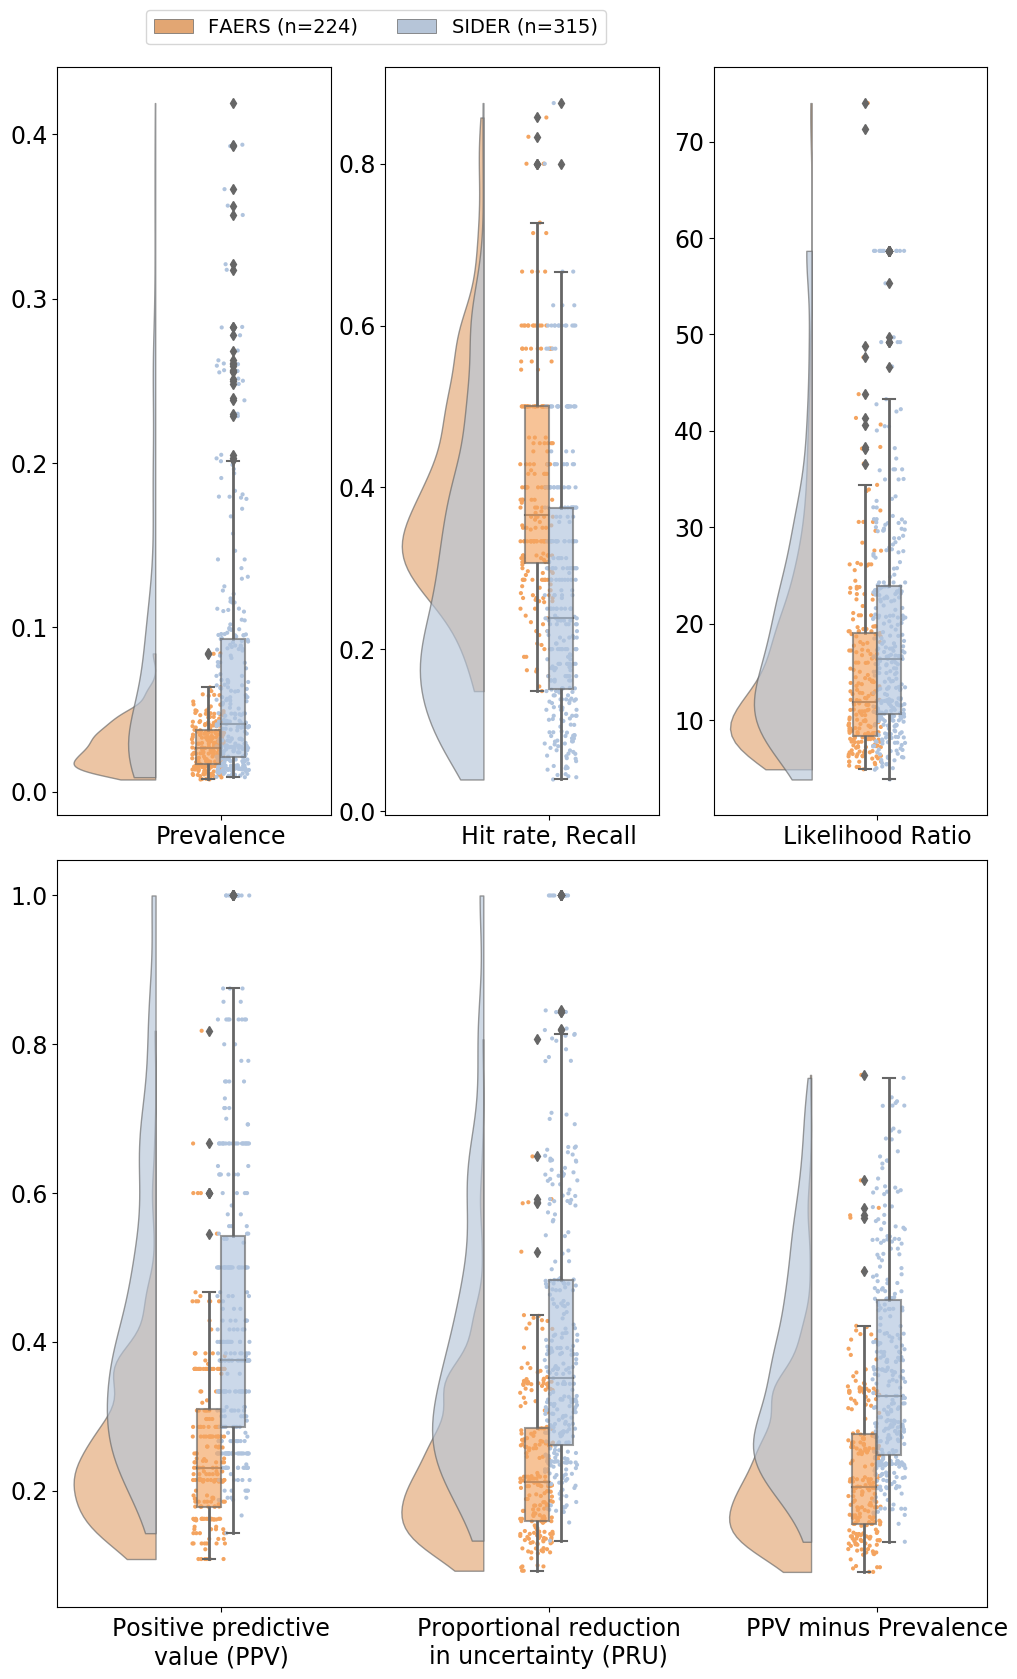

In [69]:
fig = plt.figure(figsize=(12,20))
fig.tight_layout()
ax1 = fig.add_subplot(231)
ax=pt.RainCloud(y='values', x='variable_type', hue = 'Dataset', data = prev_df, palette = my_pal, bw = .3,
                 width_viol = .5, ax = ax1, orient = 'v' , alpha = .65, dodge = True)
ax2 = fig.add_subplot(232)
ax=pt.RainCloud(y='values', x='variable_type', hue = 'Dataset', data = recall_df, palette = my_pal, bw = .3,
                 width_viol = .5, ax = ax2, orient = 'v' , alpha = .65, dodge = True)
ax3 = fig.add_subplot(233)
ax=pt.RainCloud(y='values', x='variable_type', hue = 'Dataset', data = lr_df, palette = my_pal, bw = .3,
                 width_viol = .5, ax = ax3, orient = 'v' , alpha = .65, dodge = True)
ax4 = fig.add_subplot(212)
ax=pt.RainCloud(y='values', x='variable_type', hue = 'Dataset', data = ppv_etc_df, palette = my_pal, bw = .3,
                 width_viol = .5, ax = ax4, orient = 'v' , alpha = .65, dodge = True)

ax3.set_xlabel('')
ax3.set_ylabel('')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax4.set_ylabel('')
ax4.set_xlabel('')
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)
ax3.legend().set_visible(False)
fig.subplots_adjust(hspace=0.06)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=14, bbox_to_anchor=(0.6,2.15), ncol=2)

plt.savefig(basedir + f'/analysis/results/{combined_destination_dir}/Perf_metrics_all_raincloud.png', bbox_inches='tight', dpi=150)

In [53]:
ppv_etc_df2 = pd.concat([ppv_df, improv_df, recall_df])

In [54]:
pt.RainCloud

<function ptitprince.PtitPrince.RainCloud(x=None, y=None, hue=None, data=None, order=None, hue_order=None, orient='v', width_viol=0.7, width_box=0.15, palette='Set2', bw=0.2, linewidth=1, cut=0.0, scale='area', jitter=1, move=0.0, offset=None, point_size=3, ax=None, pointplot=False, alpha=None, dodge=False, linecolor='red', **kwargs)>

In [61]:
my_pal = ['sandybrown', 'steelblue']
my_pal = ['sandybrown', 'lightsteelblue']

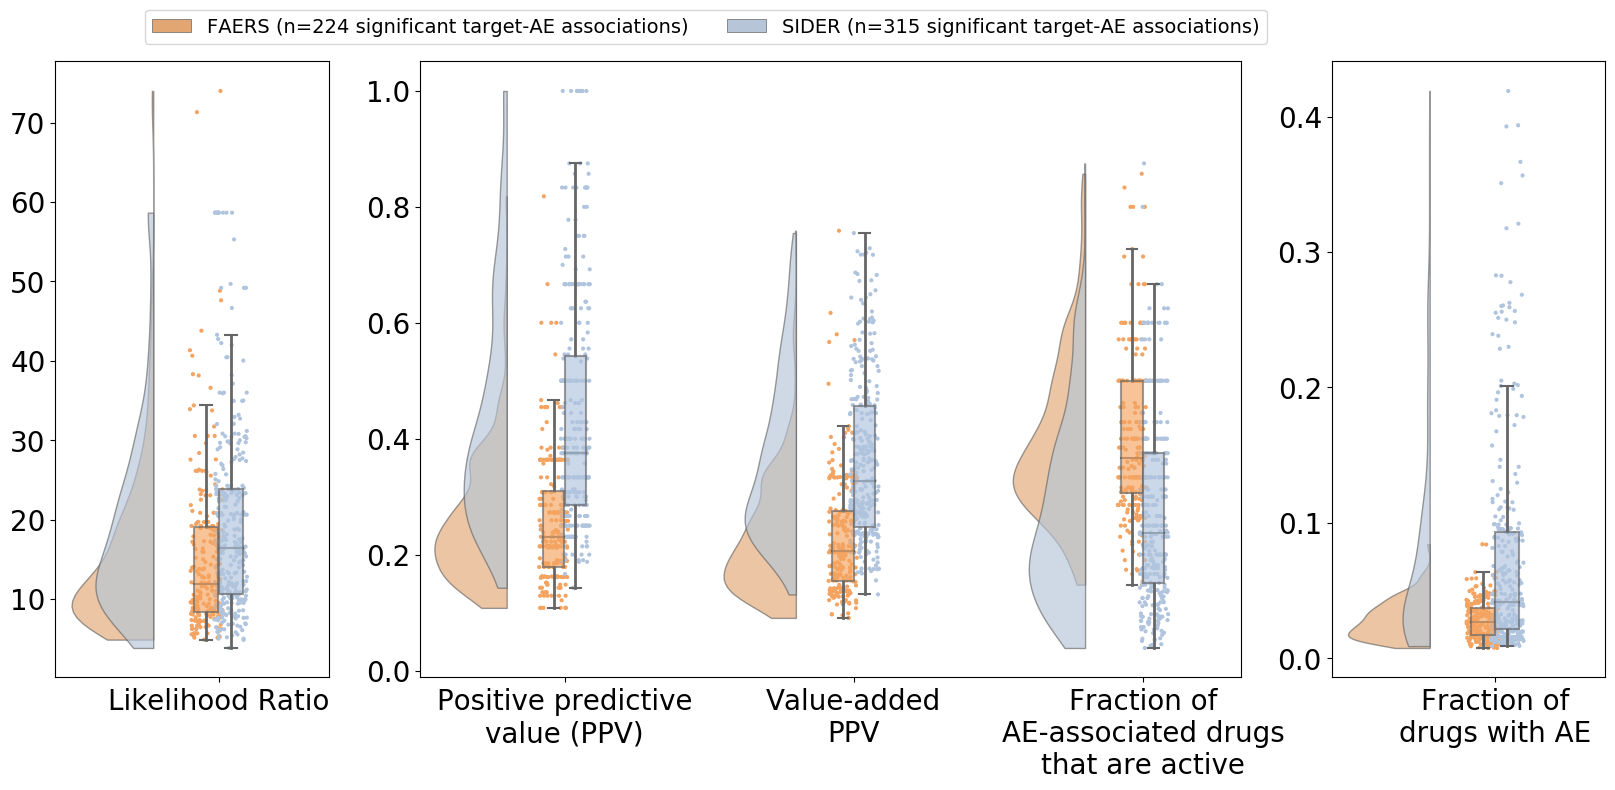

In [84]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,8), gridspec_kw={'width_ratios': [1,3,1]})

ax=pt.RainCloud(y='values', x='variable_type', hue = 'Dataset', data = prev_df, palette = my_pal, bw = .3,
                 width_viol = .5, ax = ax3, orient = 'v' , alpha = .65, dodge = True, box_showfliers = False)
ax=pt.RainCloud(y='values', x='variable_type', hue = 'Dataset', data = lr_df, palette = my_pal, bw = .3,
                 width_viol = .5, ax = ax1, orient = 'v' , alpha = .65, dodge = True, box_showfliers = False)
ax=pt.RainCloud(y='values', x='variable_type', hue = 'Dataset', data = ppv_etc_df2, palette = my_pal, bw = .3,
                 width_viol = .5, ax = ax2, orient = 'v' , alpha = .65, dodge = True, box_showfliers = False)

ax3.set_xlabel('')
ax3.set_ylabel('')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax1.legend().set_visible(False)
ax2.legend().set_visible(False)
ax3.legend().set_visible(False)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=14, bbox_to_anchor=(-0.2,1.1), ncol=2)

plt.savefig(basedir + f'/analysis/results/{combined_destination_dir}/Perf_metrics_all_raincloud_horizontal.png', bbox_inches='tight', dpi=150)

In [148]:
ppv_df.groupby('dataset')['values'].describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
FAERS,224.0,0.259288,0.107935,0.108108,0.178571,0.230769,0.310315,0.818182
SIDER,315.0,0.437180,0.198342,0.142857,0.285714,0.375000,0.541958,1.000000


In [150]:
lr_df.groupby('dataset')['values'].describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
FAERS,224.0,15.130981,10.149628,4.883908,8.323144,11.870370,19.065306,74.000000
SIDER,315.0,19.460402,12.165047,3.827243,10.660714,16.363636,23.849624,58.666667


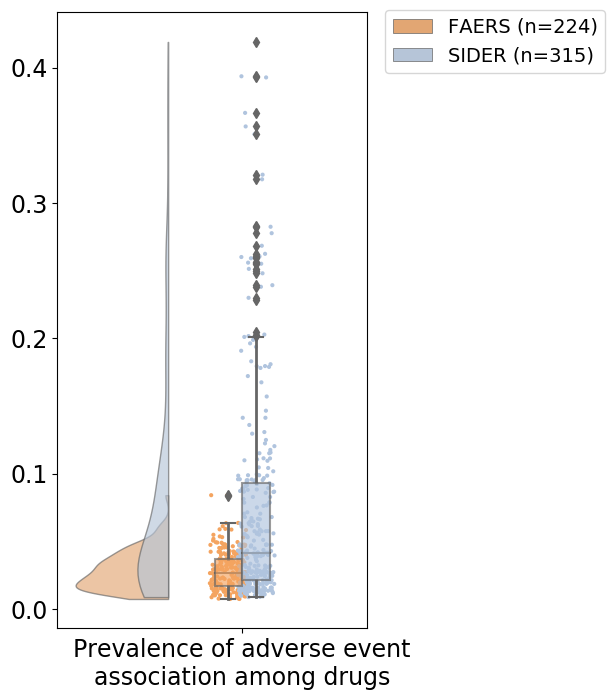

In [101]:
f, ax1 = plt.subplots(1,1, figsize=(4,8))
ax=pt.RainCloud(y='values', x='variable_type', hue = 'Dataset', data = prev_df, palette = my_pal, bw = .3,
                 width_viol = .5, ax = ax1, orient = 'v' , alpha = .65, dodge = True)
ax1.set_xlabel('')
ax1.set_ylabel('')
#ax1.legend().set_visible(False)
handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=14, bbox_to_anchor=(1.8,1.02), ncol=1)

plt.savefig(basedir + f'/analysis/results/{combined_destination_dir}/Prevalence_only.png', bbox_inches='tight', dpi=150)

In [84]:
prev_df.groupby('dataset')['values'].median()

dataset
FAERS    0.026520
SIDER    0.041339
Name: values, dtype: float64

### Relationship between PPV, LR and prevalence

In [418]:
def do_joint_plot(df1, df1_name, df1_color, df2, df2_name, df2_color, alpha, output_dir, fig_title, column_x, column_y, xbins_supplied, ybins_supplied):
    plt.rcdefaults()
    plt.rcParams.update({'font.size': 15})

    markers = iter(['x','x'])
    colours = iter([df1_color, df2_color])
    distances = [0.1,0.2,0.3,0.4]
    
    df1['kind'] = df1_name
    df2['kind'] = df2_name
    concat_df = pd.concat([df1, df2], sort=False)
    #concat_df.rename(columns={'PPV': "Positive predictive value"}, inplace=True)
    
    def multivariateGrid(output_dir, col_x, col_y, col_k, df, k_is_color=False, scatter_alpha=alpha):
        plt.rc('axes', labelsize=14)
        plt.rcParams['xtick.labelsize'] = 14
        plt.rcParams['ytick.labelsize'] = 14

        def colored_scatter(x,y,c=None):
            def scatter(*args, **kwargs):
                args = (x, y)
                if c is not None:
                    kwargs['c'] = c
                kwargs['alpha'] = scatter_alpha
                kwargs['s'] = 3
                kwargs['marker'] = next(markers)
                plt.scatter(*args, **kwargs)
            
            return scatter

        g = sns.JointGrid(
            x=col_x,
            y=col_y,
            data=df
        )

        legends=[]
        for name, df_group in df.groupby(col_k):
            color = next(colours)
            legends.append(name)
            if k_is_color:
                color=name
            g.plot_joint(
                colored_scatter(df_group[col_x],df_group[col_y],color),
            )
            
            sns.distplot(
                df_group[col_x].values,
                ax=g.ax_marg_x,
                color=color,
                kde=False,
                norm_hist=True,
                bins=xbins_supplied
                #bins=np.arange(0, max(concat_df[column_x])+0.05, 0.025) #1.05
            )
            sns.distplot(
                df_group[col_y].values,
                ax=g.ax_marg_y,
                color=color,
                vertical=True,
                kde=False,
                norm_hist=True,
                bins=ybins_supplied
                #bins=np.arange(0, 90, 5)
                #bins=np.arange(0, max(concat_df[column_y])+0.05, 0.05) #1.05
            )
        plt.legend(legends, loc=4, fontsize=12) # bbox_to_anchor=(1.2, 1)
                
        #plt.xlim([0, 1])
        current_date = datetime.date.today().strftime("%Y%m%d")
        plt.savefig(output_dir + '/{}_{}.png'.format(current_date, fig_title), dpi=200, bbox_inches='tight')
        
        
    multivariateGrid(output_dir, col_x=column_x, col_y=column_y, df=concat_df, col_k='kind')
    plt.clf()
    plt.cla()
    plt.close()

In [415]:
faers_sign_no_inf = combined_sign_no_inf.loc[combined_sign_no_inf['dataset']=='FAERS']
sider_sign_no_inf = combined_sign_no_inf.loc[combined_sign_no_inf['dataset']=='SIDER']

In [430]:
faers_sign_no_inf.rename(columns={'PPV': "Positive predictive value", 'ae_prevalence': "Prevalence", 'PRU': 'Proportional reduction in uncertainty'}, inplace=True)
sider_sign_no_inf.rename(columns={'PPV': "Positive predictive value", 'ae_prevalence': "Prevalence", 'PRU': 'Proportional reduction in uncertainty'}, inplace=True)

/scratch/ias41/envs/rainpy/lib/python3.6/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [388]:
faers_sign_no_inf.columns

Index(['pref_name', 'nr compounds', 'nr compounds with AE', 'ae_hit_rate',
       'nr compounds without AE', 'nae_hit_rate', 'nr compounds active',
       'nr compounds inactive', 'Adverse Event', 'Likelihood Ratio',
       'corrected p-value', 'PPV', 'ae_prevalence', 'dataset', 'accession',
       'PRU', 'improvement_over_prevalence', 'specificity', 'kind'],
      dtype='object')

In [421]:
max_prevalence = max(pd.concat([faers_sign_no_inf, sider_sign_no_inf])['Prevalence'])
max_ppv = max(pd.concat([faers_sign_no_inf, sider_sign_no_inf])['Positive predictive value'])
do_joint_plot(df1=faers_sign_no_inf, df1_name='FAERS', df1_color='orange', df2=sider_sign_no_inf, df2_name='SIDER', df2_color='blue', alpha=0.4, output_dir=basedir + f'/analysis/results/{combined_destination_dir}', fig_title='PPV_prevalence_sign', column_x='Prevalence', column_y='Positive predictive value', xbins_supplied = np.arange(0, max_prevalence+0.05, 0.02), ybins_supplied=np.arange(0,max_ppv+0.05, 0.05))

/scratch/ias41/envs/rainpy/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/scratch/ias41/envs/rainpy/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [427]:
max_lr = max(pd.concat([faers_sign_no_inf, sider_sign_no_inf])['Likelihood Ratio'])
do_joint_plot(df1=faers_sign_no_inf, df1_name='FAERS', df1_color='orange', df2=sider_sign_no_inf, df2_name='SIDER', df2_color='blue', alpha=0.4, output_dir=basedir + f'/analysis/results/{combined_destination_dir}', fig_title='LR_prevalence_sign', column_x='Prevalence', column_y='Likelihood Ratio', xbins_supplied = np.arange(0, max_prevalence+0.05, 0.02), ybins_supplied=np.arange(0,max_lr+0.05, 3))

/scratch/ias41/envs/rainpy/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/scratch/ias41/envs/rainpy/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [434]:
max_pru = max(pd.concat([faers_sign_no_inf, sider_sign_no_inf])['Proportional reduction in uncertainty'])
do_joint_plot(df1=faers_sign_no_inf, df1_name='FAERS', df1_color='orange', df2=sider_sign_no_inf, df2_name='SIDER', df2_color='blue', alpha=0.4, output_dir=basedir + f'/analysis/results/{combined_destination_dir}', fig_title='PRU_prevalence_sign', column_x='Prevalence', column_y='Proportional reduction in uncertainty', xbins_supplied = np.arange(0, max_prevalence+0.05, 0.02), ybins_supplied=np.arange(0,max_pru+0.05, 0.05))

/scratch/ias41/envs/rainpy/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/scratch/ias41/envs/rainpy/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
